# The process of developing a solution of the top 15%

<center>Pavel Nesterov</center>
<center>http://pavelnesterov.info/</center>

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 500)
import seaborn as sns
sns.set_style("dark")
plt.rcParams['figure.figsize'] = 16, 12
from tqdm import tqdm, tqdm_notebook
import itertools as it
import pickle
import glob
import os
import string

from scipy import sparse

import nltk
import spacy

from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, make_scorer
from sklearn.decomposition import TruncatedSVD

from scipy.optimize import minimize

import eli5
from IPython.display import display

import xgboost as xgb

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df_train = pd.read_csv('data/train.csv', 
                       dtype={
                           'question1': np.str,
                           'question2': np.str
                       })
df_train['test_id'] = -1
df_test = pd.read_csv('data/test.csv', 
                      dtype={
                          'question1': np.str,
                          'question2': np.str
                      })
df_test['id'] = -1
df_test['qid1'] = -1
df_test['qid2'] = -1
df_test['is_duplicate'] = -1

df = pd.concat([df_train, df_test])
df['question1'] = df['question1'].fillna('')
df['question2'] = df['question2'].fillna('')
df['uid'] = np.arange(df.shape[0])
df = df.set_index(['uid'])
print (df.dtypes)
del(df_train, df_test)

id               int64
is_duplicate     int64
qid1             int64
qid2             int64
question1       object
question2       object
test_id          int64
dtype: object


In [3]:
ix_train = np.where(df['id'] >= 0)[0]
ix_test = np.where(df['id'] == -1)[0]
ix_is_dup = np.where(df['is_duplicate'] == 1)[0]
ix_not_dup = np.where(df['is_duplicate'] == 0)[0]

In [4]:
print (df[df['is_duplicate'] >= 0]['is_duplicate'].value_counts(normalize=True))

0    0.630802
1    0.369198
Name: is_duplicate, dtype: float64


# Let us study the problem

<img src="./../images/buben1.jpg" />

## Testing the test data set
<br />

In [5]:
df_submit = df.loc[ix_test][['test_id', 'is_duplicate']].copy()
df_submit['is_duplicate'] = 0.0
df_submit.to_csv('submits/0_zeros.csv', index=False)
df_submit['is_duplicate'] = 1.0
df_submit.to_csv('submits/0_ones.csv', index=False)
df_submit['is_duplicate'] = 0.5
df_submit.to_csv('submits/0_half.csv', index=False)
df_submit['is_duplicate'] = 0.25
df_submit.to_csv('submits/0_quarter.csv', index=False)
df_submit['is_duplicate'] = 0.75
df_submit.to_csv('submits/0_threequarters.csv', index=False)

In [6]:
score0 = 6.01888
score1 = 28.52056
score05 = 0.69315
score025 = 0.47913
score075 = 1.19485

Let us recall the hypothesis risk formula:
$$\large Q\left(h\right) = \text{E}_{x, y \sim p\left(x, y\right)}\left[L\left(h\left(x\right), y\right)\right]$$

Then empirical risk has the form:
$$\large Q_{\text{emp}}\left(h\right) = \frac{1}{n}\sum_{i = 1}^n L\left(h\left(x_i\right), y_i\right)$$

Although if we know that the distribution of labels is not uniform, then this can be taken into account by adding the weight of the example:
$$\large Q_{\text{emp}}\left(h\right) = \sum_{i = 1}^n w_i L\left(h\left(x_i\right), y_i\right)$$
- Where $\sum_{i=1}^n w_i = 1$


In the Quora Question Pairs task, $L$ is the metric logloss (remember logistic regression), and the hypotheses give the probability of belonging to the class of duplicates $h\left(x_i\right) = p_i$:
$$\large\begin{array}{rcl}
Q_{\text{emp}} &=& \frac{1}{n}\sum_{i = 1}^n L\left(h\left(x_i\right), y_i\right) \\
&=& -\frac{1}{n}\sum_{i = 1}^n y_i \log p_i + \left(1 - y_i\right)\log\left(1 - p_i\right) \\
&=& -\frac{1}{n}\sum_{i \in I_0} \log\left(1 - p_i\right) - \frac{1}{n}\sum_{i \in I_1} \log p_i
\end{array}$$


Let's pretend that $\forall p_i = 0$, the equation <font color="blue">(1)</font>:
$$\large\begin{array}{rcl}
q_0 &\approx& -\frac{1}{n}\sum_{i \in I_0} \log\left(1 - \epsilon\right) - \frac{1}{n}\sum_{i \in I_1} \log \epsilon \\
&=& -\frac{n_0}{n}\log\left(1 - \epsilon\right) - \frac{n_1}{n} \log \epsilon \\
&=& -r_0\log\left(1 - \epsilon\right) - r_1 \log \epsilon
\end{array}$$

$\forall p_i = 1$, the equation <font color="blue">(2)</font>:
$$\large\begin{array}{rcl}
q_1 &\approx& -r_0\log \epsilon - r_1 \log \left(1 - \epsilon\right)
\end{array}$$

$\forall p_i = \frac{1}{2}$, the equation <font color="blue">(3)</font>:
$$\large\begin{array}{rcl}
q_{1/2} &=& -r_0\log \frac{1}{2} - r_1 \log \frac{1}{2} \\
&=& \left(r_0 + r_1\right) \log 2
\end{array}$$

<font color="blue">(1)</font> + <font color="blue">(2)</font>:
$$\large\begin{array}{rcl}
-\left(q_0+ q_1\right) &=& r_0 \log \left(1 - \epsilon\right) + r_1 \log \epsilon + r_0 \log \epsilon + r_1 \log \left(1 - \epsilon\right) \\
&=& \left(r_0 + r_1\right) \log \epsilon \left(1 - \epsilon\right)
\end{array}$$


Using equation <font color="blue">(3)</font>, Calculate $\epsilon$:
$$\large\begin{array}{rcl}
-\left(q_0+ q_1\right) &=& \frac{q_{1/2}}{\log 2} \log \epsilon \left(1 - \epsilon\right) \Leftrightarrow \\
\log \epsilon \left(1 - \epsilon\right) &=& \frac{q_0 + q_1}{q_{1/2}} \log \frac{1}{2} \Leftrightarrow \\
\log \epsilon \left(1 - \epsilon\right) &=& A \Leftrightarrow \\
\epsilon^2 - \epsilon + e^A &=& 0 \Rightarrow \\
\epsilon &=& \frac{1}{2}\left(1 \pm \sqrt{1 - 4e^A}\right)
\end{array}$$

In [7]:
A = (score0 + score1)*np.log(0.5)/score05
print ('A =', A)
print ('eps_0 =', (1 + np.sqrt(1 - 4*np.exp(A)))/2)
print ('eps_1 =', (1 - np.sqrt(1 - 4*np.exp(A)))/2)
eps = 10e-16
print ('eps =', eps)

A = -34.5392995082
eps_0 = 1.0
eps_1 = 9.99200722163e-16
eps = 1e-15


For simplicity, we introduce two more constants:
$$\large\begin{array}{rcl}
B &=& \log \left(1 - \epsilon\right) \\
C &=& \log \epsilon
\end{array}$$

In [8]:
B = np.log(1 - eps)
print ('B =', B)
C = np.log(eps)
print ('C =', C)

B = -9.99200722163e-16
C = -34.5387763949



Solving the system of two equations <font color="blue">(1)</font> 
and <font color="blue">(2)</font>, 
We get:
$$\large\begin{array}{rcl}
r_1 &=& \frac{B\left(q_1 - \frac{C}{B}q_0\right)}{C^2 - B^2} \\
r_0 &=& \frac{1}{C}\left(-q_1 - r_1 B\right)
\end{array}$$

In [9]:
r1 = (score1 - (C/B)*score0) / ((C*C/B) - B)
print ('r1 =', r1)
r0 = (-score1 - r1*B)/C
print ('r0 =', r0)
print ('r0 + r1 =', r0 + r1)

r1 = 0.174264424749
r0 = 0.825754788586
r0 + r1 = 1.00001921334


In [10]:
if not os.path.isfile('submits/0_174.csv'):
    df_submit = df.loc[ix_test][['test_id', 'is_duplicate']].copy()
    df_submit['is_duplicate'] = 0.17426442474
    df_submit.to_csv('submits/0_174.csv', index=False)

- score0174 = **0.46258**
- At the moment of submission it is **1208/1880**

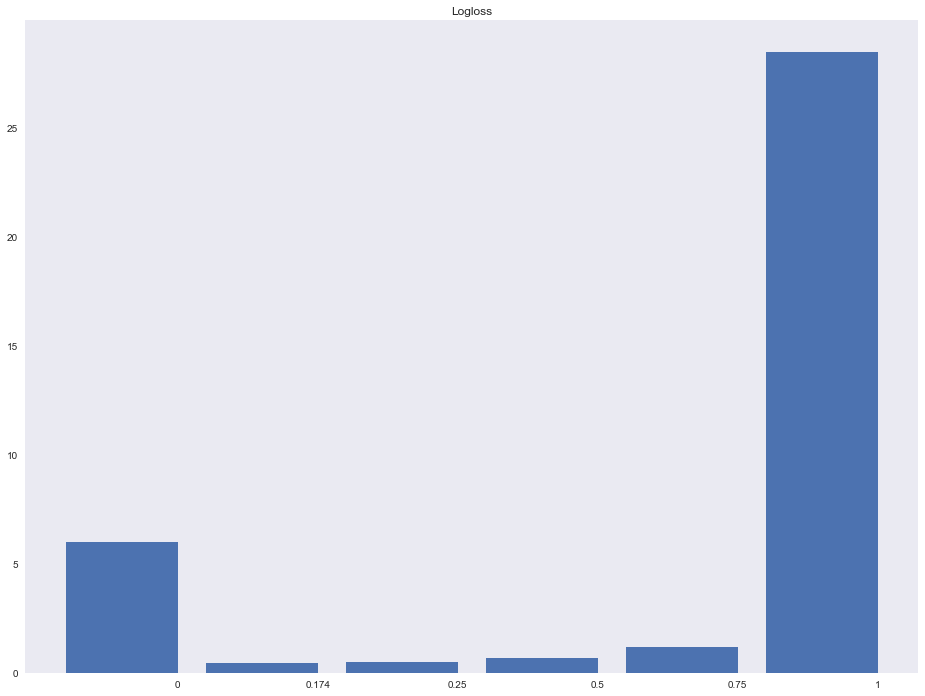

In [11]:
score0174 = 0.46258
fig, ax = plt.subplots()
ax.bar(range(6), [score0, score0174, score025, score05, score075, score1])
ax.set_title('Logloss')
ax.set_xticks(np.arange(6) + 0.4)
ax.set_xticklabels([0, 0.174, 0.25, 0.5, 0.75, 1])
plt.show()

## Correct the model forecast

It turns out that the distribution of tags on the trainee and the test is different, I would like to learn on the train, but somehow optimize the error function on the test. Let's make a reasonable assumption:
 - The trainee and test differ only in the distribution of classes, but not in classes:
  - $\forall i: p\left(X \mid y = i\right) = p\left(X' \mid y' = i\right)$, Where $\left(X, y\right) \sim p_{\text{train}}$, $\left(X', y'\right) \sim p_{\text{test}}$

Denote by $p$ The best model on the training set of data, then:

$$\large\begin{array}{rcl}
p = P\left(y = 1 \mid x\right) &=& \frac{P\left(x \mid y = 1\right)P\left(y = 1\right)}{P\left(x \mid y = 1\right)P\left(y = 1\right) + P\left(x \mid y = 0\right)P\left(y = 0\right)} \\
&=& \frac{a p_1}{a p_1 + b p_0} \Rightarrow \\
b p_0 &=& \frac{a p_1}{p} - a p_1 = \frac{a p_1 - a p_1 p}{p}
\end{array}$$


By assumption, the distribution of labels on the test is simply oblique, i.e $P\left(y' = i\right) = \gamma_i P\left(y = 1\right)$, then:

$$\large\begin{array}{rcl}
P\left(y' = 1 \mid x\right) &=& \frac{P\left(x \mid y' = 1\right)P\left(y' = 1\right)}{P\left(x \mid y' = 1\right)P\left(y' = 1\right) + P\left(x \mid y' = 0\right)P\left(y' = 0\right)} \\
&=& \frac{a\gamma_1p_1}{a\gamma_1p_1 + b\gamma_0p_0} \\
&=& \frac{a\gamma_1p_1}{a\gamma_1p_1 + \gamma_0\frac{a p_1 - a p_1 p}{p}} \\
&=& \frac{a\gamma_1p_1p}{a\gamma_1p_1p + \gamma_0a p_1 - \gamma_0a p_1 p} \\
&=& \frac{\gamma_1 p}{\gamma_1 p + \gamma_0 - \gamma_0 p} \\
&=& \frac{\gamma_1 p}{\gamma_1 p + \gamma_0 \left(1 - p\right)} \\
\end{array}$$


It turns out that the forecast of the model, trained on the training set, must be converted before sending by using the function:
$$\large f\left(x\right) = \frac{\gamma_1 x}{\gamma_1 x + \gamma_0 \left(1 - x\right)}$$

P(y = 0) = 0.630802146974
P(y = 1) = 0.369197853026
P(y' = 0) = 0.825754788586
P(y' = 1) = 0.174264424749
gamma_0 = 1.30905513329
gamma_1 = 0.472008228977


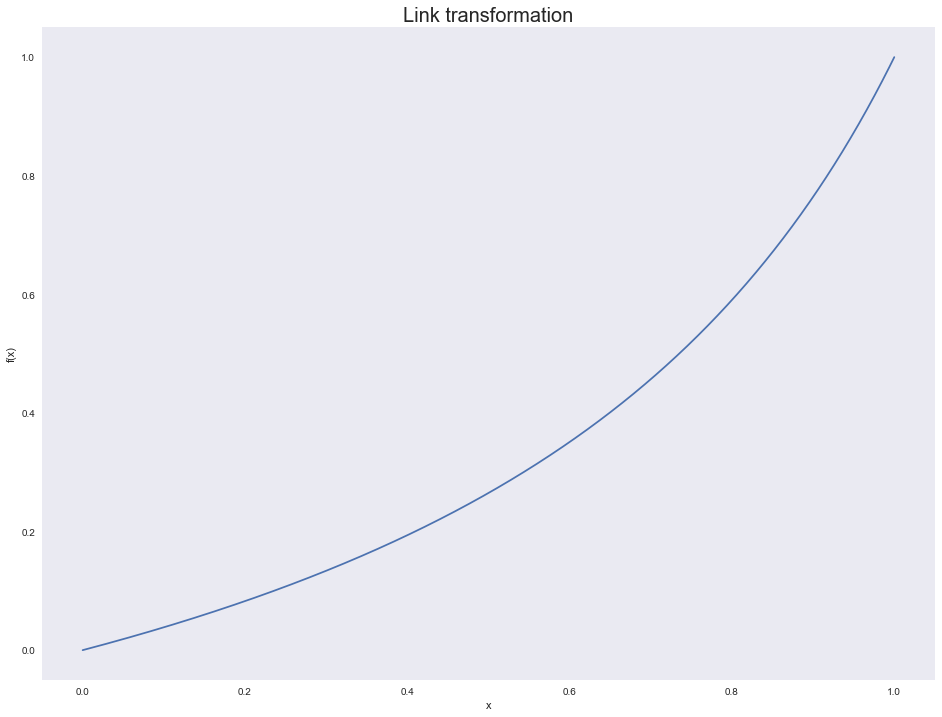

In [12]:
d = df[df['is_duplicate'] >= 0]['is_duplicate'].value_counts(normalize=True).to_dict()
print ('P(y = 0) =', d[0])
print ('P(y = 1) =', d[1])
print ('P(y\' = 0) =', r0)
print ('P(y\' = 1) =', r1)
gamma_0 = r0/d[0]
gamma_1 = r1/d[1]
print ('gamma_0 =', gamma_0)
print ('gamma_1 =', gamma_1)

def link_function(x):
    return gamma_1*x/(gamma_1*x + gamma_0*(1 - x))

support = np.linspace(0, 1, 1000)
values = link_function(support)

fig, ax = plt.subplots()
ax.plot(support, values)
ax.set_title('Link transformation', fontsize=20)
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
plt.show()

# Feature engineering

<img src="./../images/buben2.jpg" width="50%" />

## Length of question
<br />

In [13]:
df['len1'] = df['question1'].str.len().astype(np.float32)
df['len2'] = df['question2'].str.len().astype(np.float32)
df['abs_diff_len1_len2'] = np.abs(df['len1'] - df['len2'])

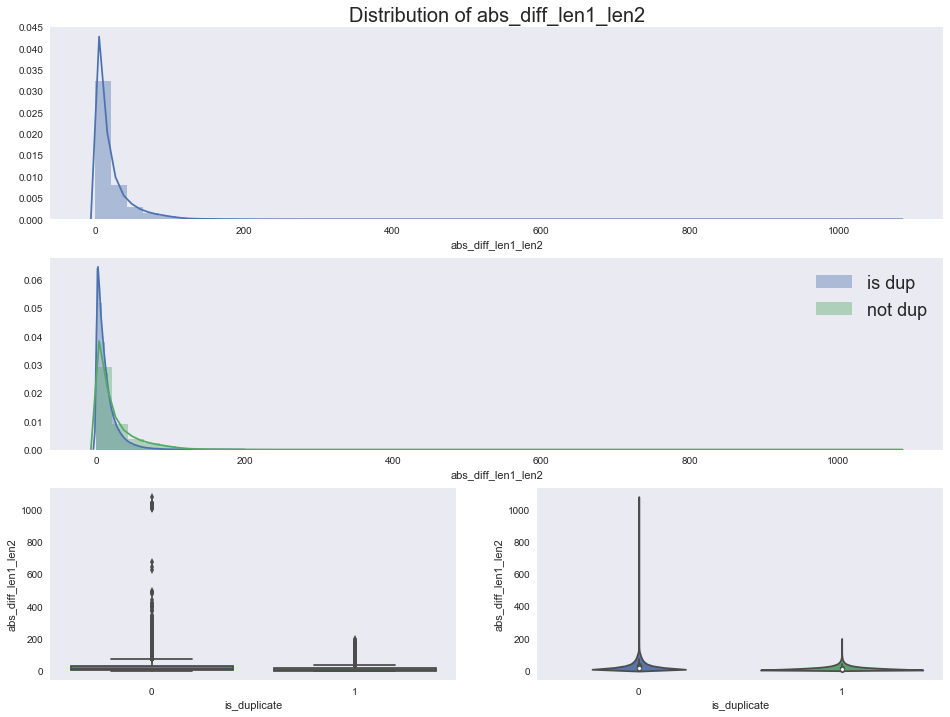

In [14]:
def plot_real_feature(fname):
    fig = plt.figure()
    ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 2), (1, 0), colspan=2)
    ax3 = plt.subplot2grid((3, 2), (2, 0))
    ax4 = plt.subplot2grid((3, 2), (2, 1))
    ax1.set_title('Distribution of %s' % fname, fontsize=20)
    sns.distplot(df.loc[ix_train][fname], 
                 bins=50, 
                 ax=ax1)    
    sns.distplot(df.loc[ix_is_dup][fname], 
                 bins=50, 
                 ax=ax2,
                 label='is dup')    
    sns.distplot(df.loc[ix_not_dup][fname], 
                 bins=50, 
                 ax=ax2,
                 label='not dup')
    ax2.legend(loc='upper right', prop={'size': 18})
    sns.boxplot(y=fname, 
                x='is_duplicate', 
                data=df.loc[ix_train], 
                ax=ax3)
    sns.violinplot(y=fname, 
                   x='is_duplicate', 
                   data=df.loc[ix_train], 
                   ax=ax4)
    plt.show()
    
plot_real_feature('abs_diff_len1_len2')

In [15]:
print (df.loc[ix_train]['abs_diff_len1_len2'].describe())

count    404290.000000
mean         20.158194
std          25.584406
min           0.000000
25%           4.000000
50%          12.000000
75%          26.000000
max        1080.000000
Name: abs_diff_len1_len2, dtype: float64


In [16]:
max_in_dup = df.loc[ix_is_dup]['abs_diff_len1_len2'].max()
print ('Maximum among duplicates:       ', max_in_dup)
max_in_not_dups = df.loc[ix_not_dup]['abs_diff_len1_len2'].max()
print ('Maximum among non-duplicates:     ', max_in_not_dups)
print ('Maximum among non-duplicates: ', (df.loc[ix_train]['abs_diff_len1_len2'] > max_in_dup).sum())
std_in_dups = df.loc[ix_is_dup]['abs_diff_len1_len2'].std()
print ('Standard deviation in duplicates:', std_in_dups)
replace_value = max_in_dup + 2*std_in_dups
print ('New value:              ', replace_value)

Maximum among duplicates:        196.0
Maximum among non-duplicates:      1080.0
Maximum among non-duplicates:  394
Standard deviation in duplicates: 14.3821
New value:               224.764198303


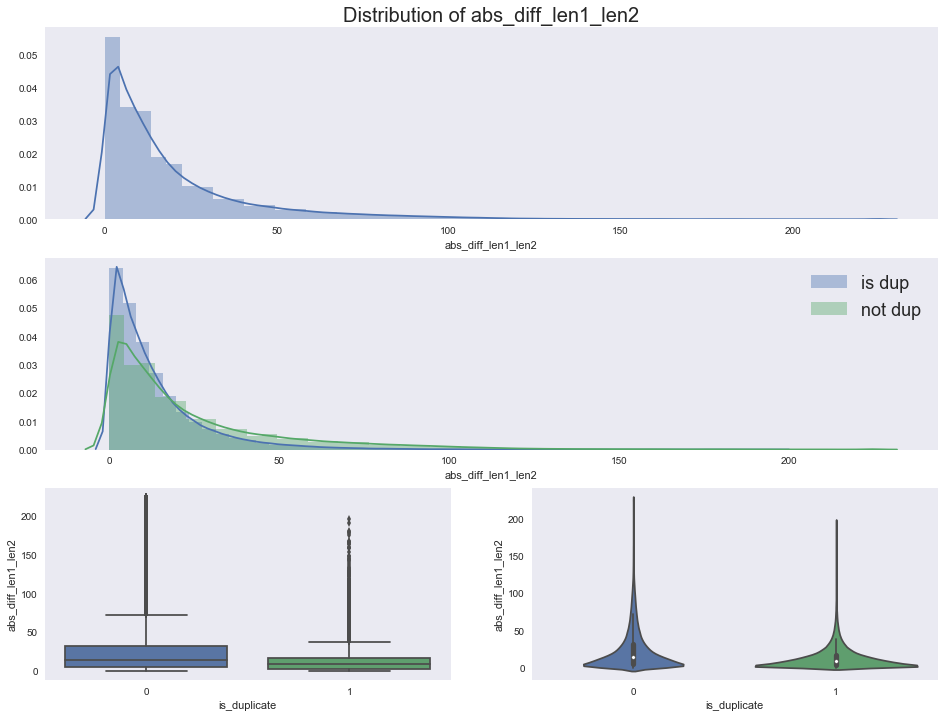

In [17]:
df['abs_diff_len1_len2'] = df['abs_diff_len1_len2'].apply(lambda x: x if x < replace_value else replace_value)
plot_real_feature('abs_diff_len1_len2')

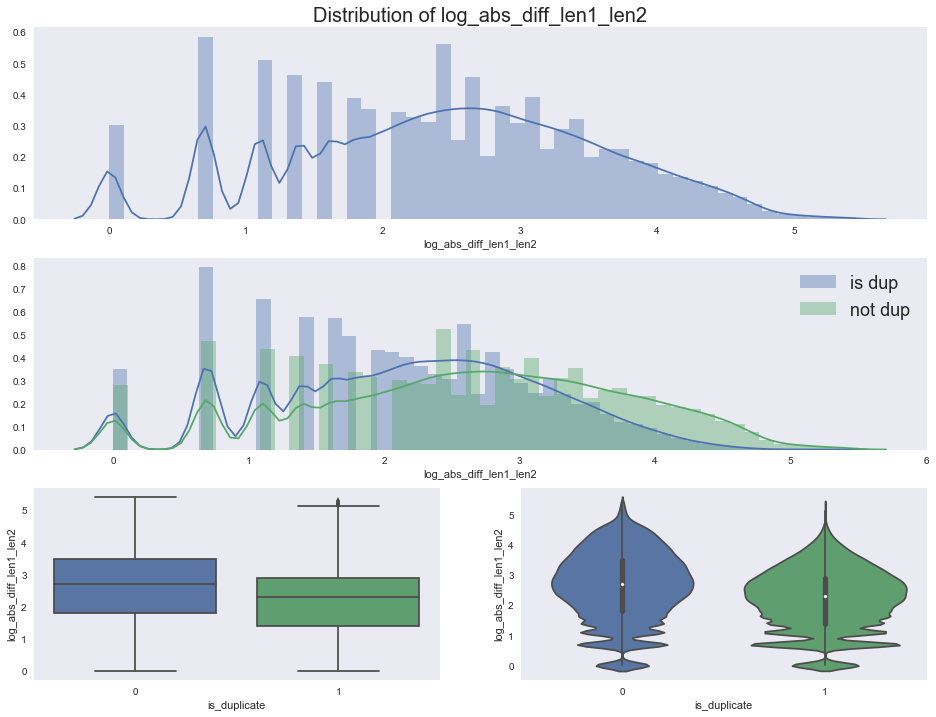

In [18]:
df['log_abs_diff_len1_len2'] = np.log(df['abs_diff_len1_len2'] + 1)
plot_real_feature('log_abs_diff_len1_len2')

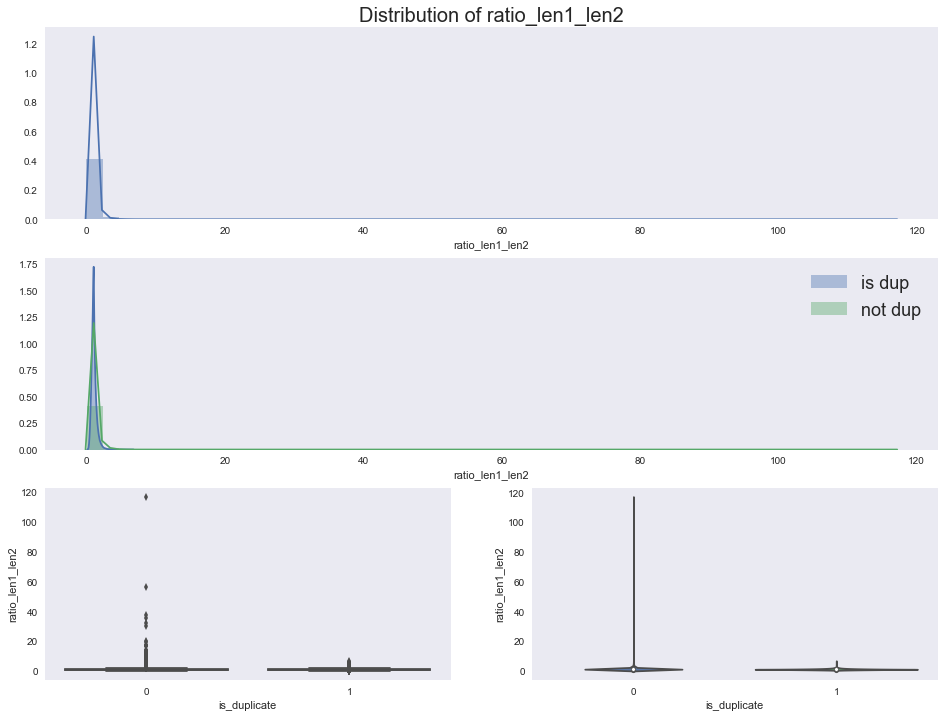

In [19]:
df['ratio_len1_len2'] = df['len1'].apply(lambda x: x if x > 0.0 else 1.0)/\
                        df['len2'].apply(lambda x: x if x > 0.0 else 1.0)
plot_real_feature('ratio_len1_len2')

In [20]:
print (df.loc[ix_train]['ratio_len1_len2'].describe())

count    404290.000000
mean          1.110796
std           0.613775
min           0.006711
25%           0.793651
50%           1.000000
75%           1.271186
max         117.000000
Name: ratio_len1_len2, dtype: float64


In [21]:
max_in_dup = df.loc[ix_is_dup]['ratio_len1_len2'].max()
print ('Maximum among duplicates:        ', max_in_dup)
max_in_not_dups = df.loc[ix_not_dup]['ratio_len1_len2'].max()
print ('Maximum among non-duplicates:      ', max_in_not_dups)
print ('Number of lines greater than threshold: ', (df.loc[ix_train]['ratio_len1_len2'] > max_in_dup).sum())
std_in_dups = df.loc[ix_is_dup]['ratio_len1_len2'].std()
print ('Number of lines greater than threshold: ', std_in_dups)
replace_value = max_in_dup + 2*std_in_dups
print ('New value:               ', replace_value)

Maximum among duplicates:         6.66666666667
Maximum among non-duplicates:       117.0
Number of lines greater than threshold:  152
Number of lines greater than threshold:  0.376106045115
New value:                7.4188787569


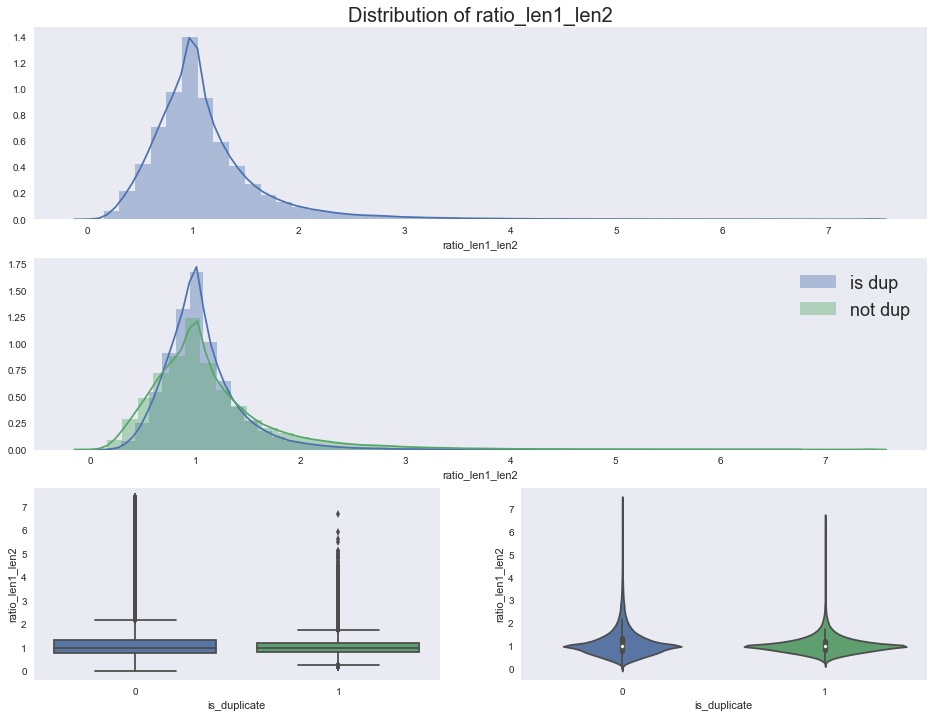

In [22]:
df['ratio_len1_len2'] = df['ratio_len1_len2'].apply(lambda x: x if x < replace_value else replace_value)
plot_real_feature('ratio_len1_len2')

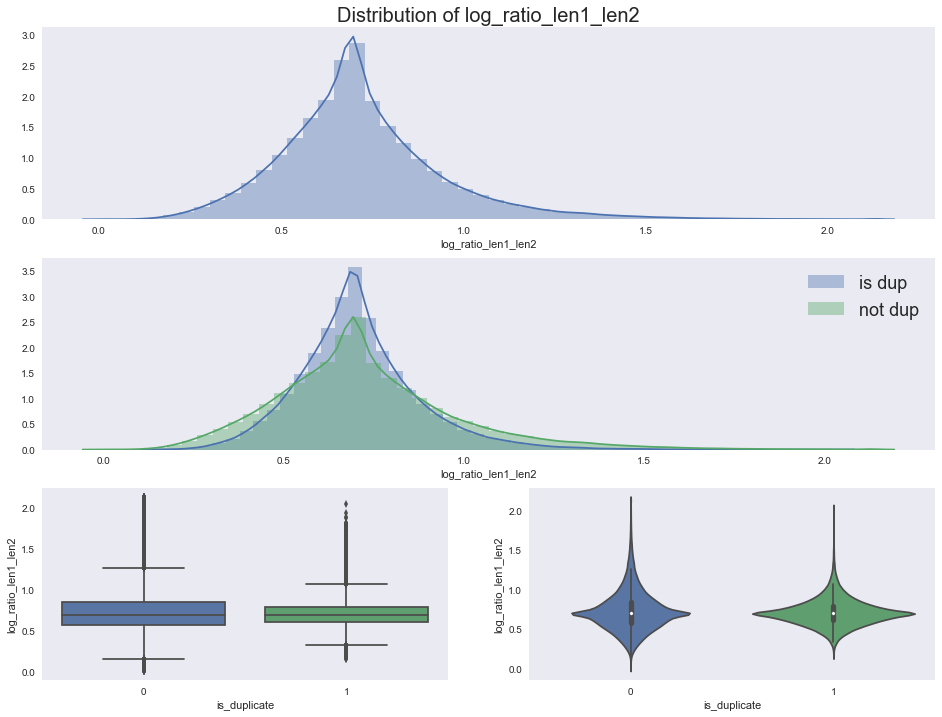

In [23]:
df['log_ratio_len1_len2'] = np.log(df['ratio_len1_len2'] + 1)
plot_real_feature('log_ratio_len1_len2')

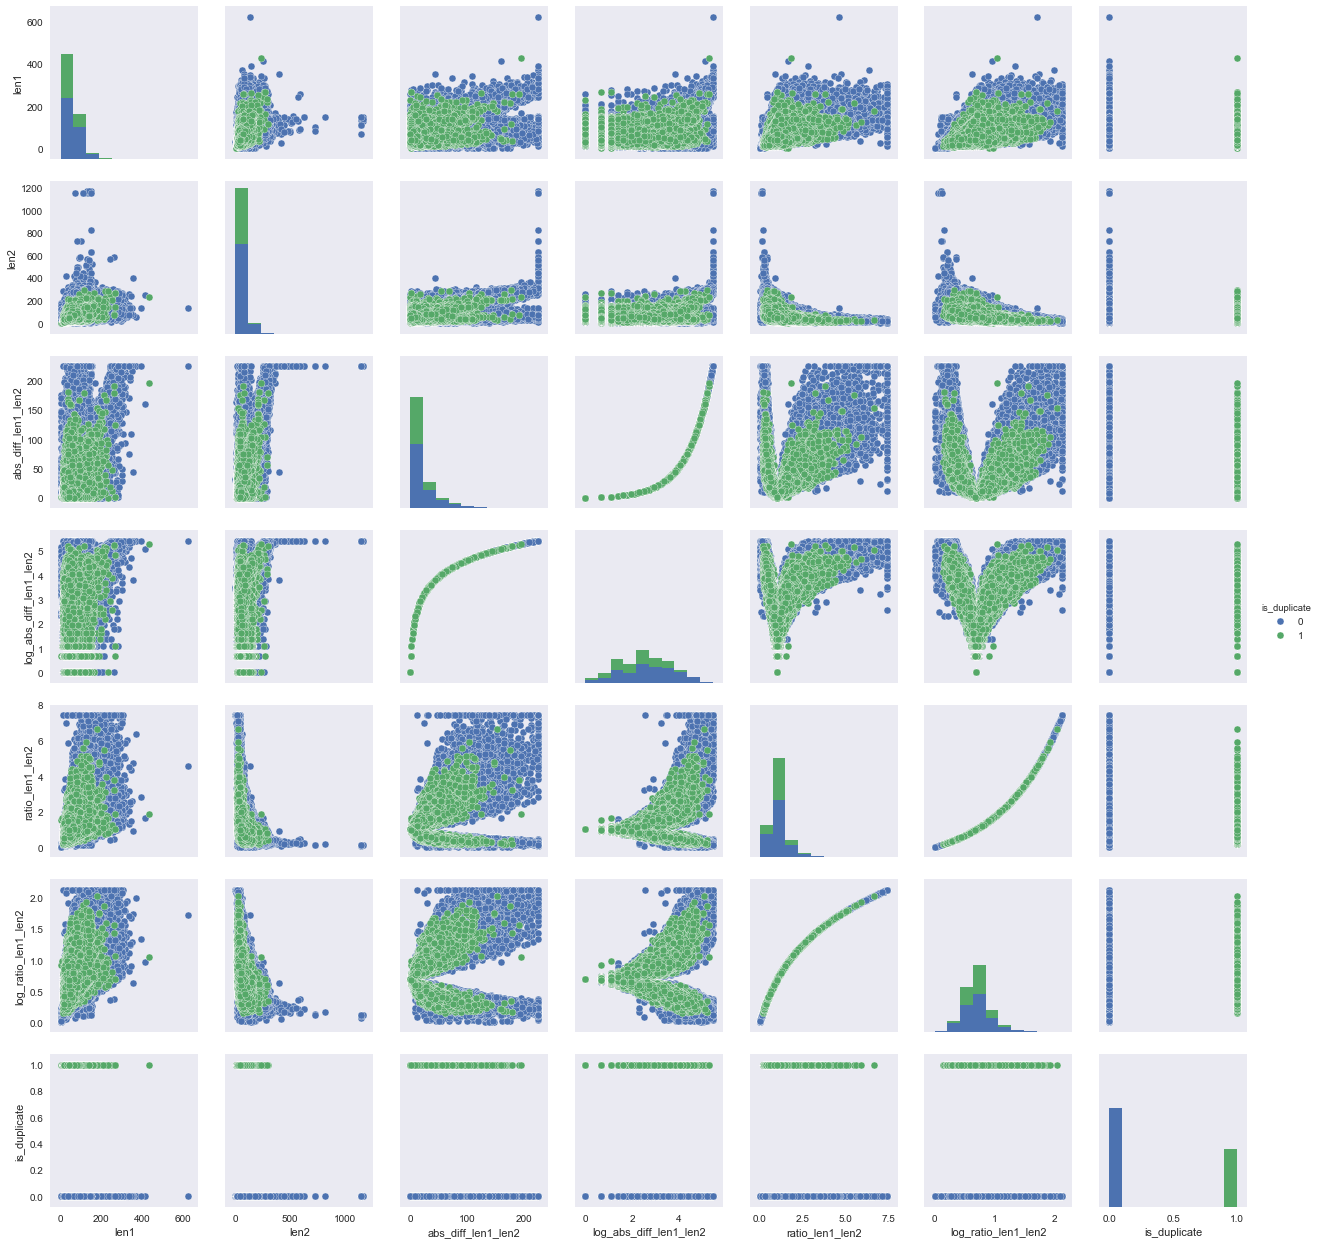

In [24]:
sns.pairplot(df.loc[ix_train][df.columns[7:].tolist() + ['is_duplicate']], hue="is_duplicate")

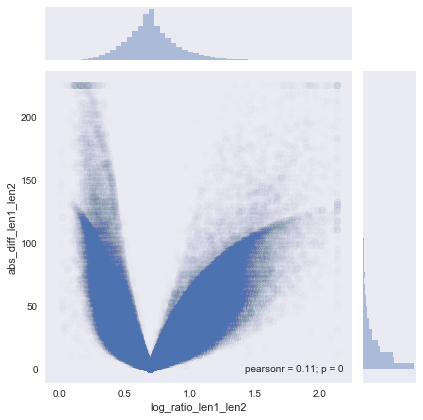

In [25]:
sns.jointplot('log_ratio_len1_len2', 'abs_diff_len1_len2', df.loc[ix_train], alpha=0.01)

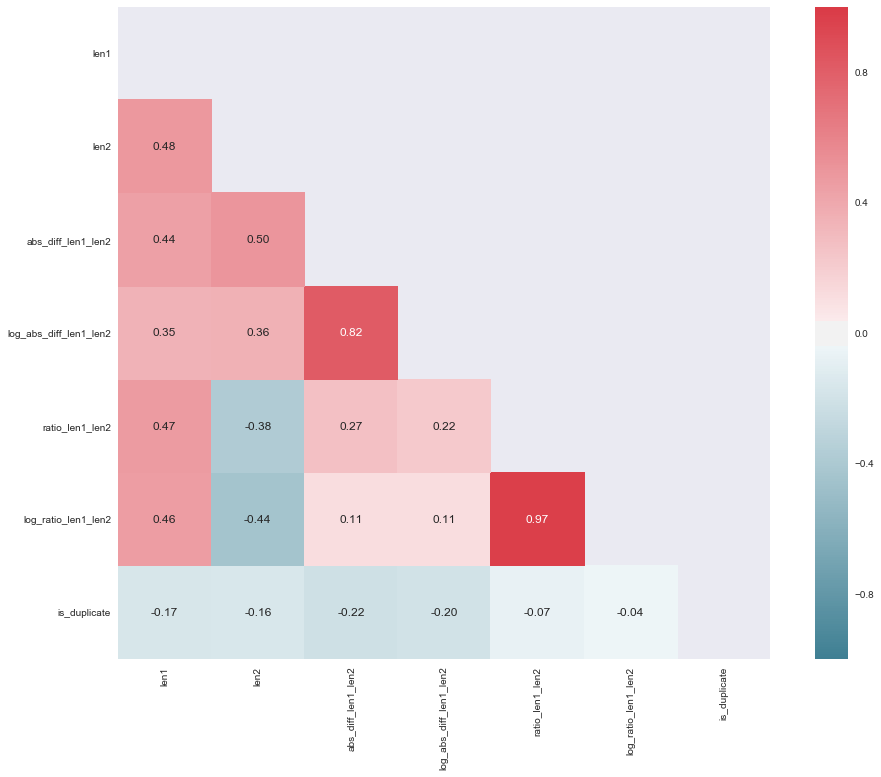

In [26]:
def plot_corr(predictors):
    predictors = predictors[:]
    predictors += ['is_duplicate']
    mcorr = df.loc[ix_train][predictors].corr()
    mask = np.zeros_like(mcorr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    g = sns.heatmap(mcorr, mask=mask, cmap=cmap, square=True, annot=True, fmt='0.2f')
    g.set_xticklabels(predictors, rotation=90)
    g.set_yticklabels(reversed(predictors))
    plt.show()
    
plot_corr(df.columns[7:].tolist())

### Check for new symptoms

In [27]:
predictors = df.columns[7:].tolist()
print (predictors)

def check_model(predictors):
    classifier = lambda: SGDClassifier(
        loss='log', 
        penalty='elasticnet', 
        fit_intercept=True, 
        n_iter=100, 
        shuffle=True, 
        n_jobs=-1,
        class_weight=None)

    model = Pipeline(steps=[
        ('ss', StandardScaler()),
        ('en', classifier())
    ])

    parameters = {
        'en__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.02, 0.1, 0.5, 0.9, 1],
        'en__l1_ratio': [0, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.75, 0.9, 1]
    }

    folder = StratifiedKFold(n_splits=5, shuffle=True)
    
    grid_search = GridSearchCV(
        model, 
        parameters, 
        cv=folder, 
        n_jobs=-1, 
        verbose=1)
    grid_search = grid_search.fit(df.loc[ix_train][predictors], 
                                  df.loc[ix_train]['is_duplicate'])
    
    return grid_search

if not os.path.isfile('tmp/1_model.pkl'):
    model = check_model(predictors)
    print (model.best_score_)
    print (model.best_params_)
    with open('tmp/1_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('tmp/1_model.pkl', 'rb') as f:
        model = pickle.load(f)

['len1', 'len2', 'abs_diff_len1_len2', 'log_abs_diff_len1_len2', 'ratio_len1_len2', 'log_ratio_len1_len2']


```python
Fitting 5 folds for each of 90 candidates, totalling 450 fits
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  5.5min finished
0.633560068268
{'en__l1_ratio': 0, 'en__alpha': 0.02}
```

<img src="./../images/htop.png" />

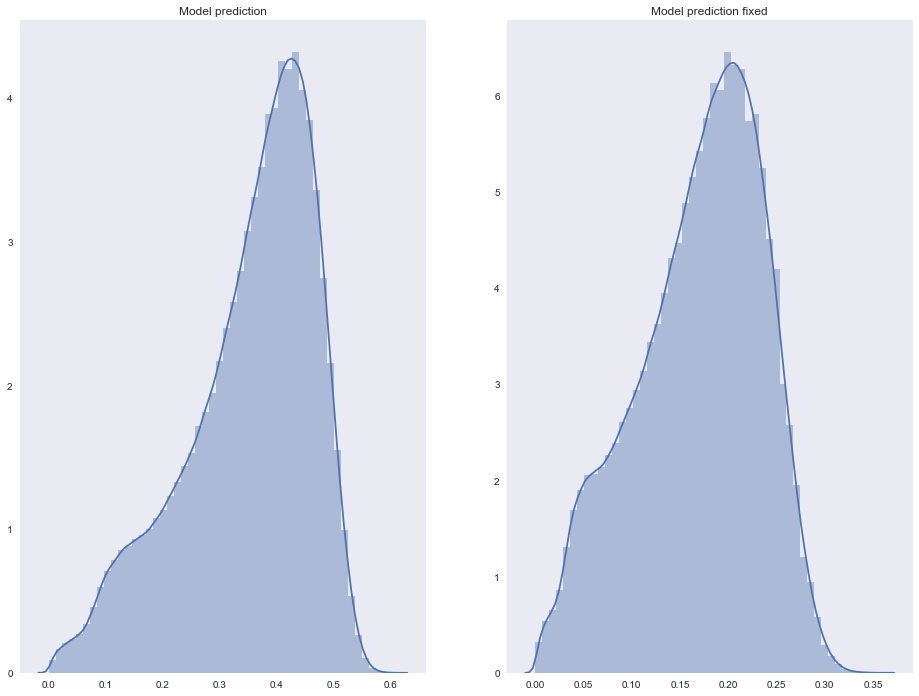

In [28]:
y_test_pred = model.predict_proba(df.loc[ix_test][predictors])[:, 1]
y_test_pred_fixed = link_function(y_test_pred)

fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
sns.distplot(y_test_pred, ax=ax1)
ax1.set_title('Model prediction')
sns.distplot(y_test_pred_fixed, ax=ax2)
ax2.set_title('Model prediction fixed')
plt.show()

In [29]:
if not os.path.isfile('submits/1_pred.csv'):
    pd.DataFrame.from_records(
        zip(df.loc[ix_test]['test_id'].values, 
            y_test_pred), 
        columns=['test_id', 'is_duplicate']).to_csv('submits/1_pred.csv', index=False)

In [30]:
if not os.path.isfile('submits/1_pred_fixed.csv'):
    pd.DataFrame.from_records(
        zip(df.loc[ix_test]['test_id'].values, 
            y_test_pred_fixed), 
        columns=['test_id', 'is_duplicate']).to_csv('submits/1_pred_fixed.csv', index=False)

- Without amendment: **0.52929**
- Amended: **0.44127**
- Previous value: **0.46258**

In [31]:
#display(    eli5.sklearn.explain_linear_classifier_weights(        model.best_estimator_.steps[1][1],        feature_names=predictors))

## Letter n-gram
<br />

In [32]:
%%time
if os.path.isfile('tmp/cv_char.pkl') and os.path.isfile('tmp/ch_freq.pkl'):
    with open('tmp/cv_char.pkl', 'rb') as f:
        cv_char = pickle.load(f)
    with open('tmp/ch_freq.pkl', 'rb') as f:
        ch_freq = pickle.load(f)
else:
    cv_char = CountVectorizer(ngram_range=(1, 2), analyzer='char')
    ch_freq = np.array(cv_char.fit_transform(df['question1'].tolist() + df['question2'].tolist()).sum(axis=0))[0, :]
    with open('tmp/cv_char.pkl', 'wb') as f:
        pickle.dump(cv_char, f)
    with open('tmp/ch_freq.pkl', 'wb') as f:
        pickle.dump(ch_freq, f)

CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 8.43 ms


In [33]:
unigrams = dict([(k, v) for (k, v) in cv_char.vocabulary_.items() if len(k) == 1])
ix_unigrams = np.sort(unigrams.values())
print ('Unigrams:', len(unigrams))
bigrams = dict([(k, v) for (k, v) in cv_char.vocabulary_.items() if len(k) == 2])
ix_bigrams = np.sort(bigrams.values())
print ('Bigrams: ', len(bigrams))
trigrams = dict([(k, v) for (k, v) in cv_char.vocabulary_.items() if len(k) == 3])
ix_trigrams = np.sort(trigrams.values())
print ('Trigrams:', len(trigrams))

ValueError: axis(=-1) out of bounds

In [ ]:
%%time
def save_sparse_csr(fname, sm):
    np.savez(fname, 
             data=sm.data, 
             indices=sm.indices,
             indptr=sm.indptr, 
             shape=sm.shape)

def load_sparse_csr(fname):
    loader = np.load(fname)
    return sparse.csr_matrix((
        loader['data'], 
        loader['indices'], 
        loader['indptr']),
        shape=loader['shape'])

if os.path.isfile('tmp/m_q1.npz') and os.path.isfile('tmp/m_q2.npz'):
    m_q1 = load_sparse_csr('tmp/m_q1.npz')
    m_q2 = load_sparse_csr('tmp/m_q2.npz')
else:
    m_q1 = cv_char.transform(df['question1'].values)
    m_q2 = cv_char.transform(df['question2'].values)
    save_sparse_csr('tmp/m_q1.npz', m_q1)
    save_sparse_csr('tmp/m_q2.npz', m_q2)

### Jaccard similarity and derivatives
$$\large\begin{array}{rcl}
J\left(A, B\right) &=& \dfrac{\left|A \cap B\right|}{\left|A \cup B\right|}
\end{array}$$

#### Unigrams

In [ ]:
v_num = (m_q1[:, ix_unigrams] > 0).minimum((m_q2[:, ix_unigrams] > 0)).sum(axis=1)
v_den = (m_q1[:, ix_unigrams] > 0).maximum((m_q2[:, ix_unigrams] > 0)).sum(axis=1)
v_score = np.array(v_num.flatten()).astype(np.float32)[0, :]/np.array(v_den.flatten())[0, :]

df['unigram_jaccard'] = v_score
plot_real_feature('unigram_jaccard')

In [ ]:
# We take into account each letter more than once
v_num = m_q1[:, ix_unigrams].minimum(m_q2[:, ix_unigrams]).sum(axis=1)
v_den = m_q1[:, ix_unigrams].sum(axis=1) + m_q2[:, ix_unigrams].sum(axis=1)
v_score = np.array(v_num.flatten()).astype(np.float32)[0, :]/np.array(v_den.flatten())[0, :]

df['unigram_all_jaccard'] = v_score
plot_real_feature('unigram_all_jaccard')

In [ ]:
# We take into account each letter more than once
# Normalize the maximum value, and not the sum
v_num = m_q1[:, ix_unigrams].minimum(m_q2[:, ix_unigrams]).sum(axis=1)
v_den = m_q1[:, ix_unigrams].maximum(m_q2[:, ix_unigrams]).sum(axis=1)
v_score = np.array(v_num.flatten()).astype(np.float32)[0, :]/np.array(v_den.flatten())[0, :]

df['unigram_all_jaccard_max'] = v_score
plot_real_feature('unigram_all_jaccard_max')

#### Bigrams

In [ ]:
v_num = (m_q1[:, ix_bigrams] > 0).minimum((m_q2[:, ix_bigrams] > 0)).sum(axis=1)
v_den = (m_q1[:, ix_bigrams] > 0).maximum((m_q2[:, ix_bigrams] > 0)).sum(axis=1)
v_score = np.array(v_num.flatten()).astype(np.float32)[0, :]/np.array(v_den.flatten())[0, :]

df['bigram_jaccard'] = v_score
plot_real_feature('bigram_jaccard')

In [ ]:
df.loc[ix_train].groupby(['is_duplicate'])['bigram_jaccard'].agg(
    {
        'min': np.min,
        'max': np.max,
        'p1': lambda x: np.percentile(x, q=0.01),
        'p99': lambda x: np.percentile(x, q=99.99)
    }
)

In [ ]:
print ('Number of right speakers on the right:', (df['bigram_jaccard'] > 1).sum())
print ('Number of outsiders on the left: ', (df['bigram_jaccard'] < -1.47).sum())

In [ ]:
df.loc[df['bigram_jaccard'] < -1.478751, 'bigram_jaccard'] = -1.478751
df.loc[df['bigram_jaccard'] > 1.0, 'bigram_jaccard'] = 1.0
plot_real_feature('bigram_jaccard')

In [ ]:
# We take into account each letter more than once
v_num = m_q1[:, ix_bigrams].minimum(m_q2[:, ix_bigrams]).sum(axis=1)
v_den = m_q1[:, ix_bigrams].sum(axis=1) + m_q2[:, ix_bigrams].sum(axis=1)
v_score = np.array(v_num.flatten()).astype(np.float32)[0, :]/np.array(v_den.flatten())[0, :]

df['bigram_all_jaccard'] = v_score
plot_real_feature('bigram_all_jaccard')

In [ ]:
# We take into account each letter more than once
# Normalize the maximum value, and not the sum
v_num = m_q1[:, ix_bigrams].minimum(m_q2[:, ix_bigrams]).sum(axis=1)
v_den = m_q1[:, ix_bigrams].maximum(m_q2[:, ix_bigrams]).sum(axis=1)
v_score = np.array(v_num.flatten()).astype(np.float32)[0, :]/np.array(v_den.flatten())[0, :]

df['bigram_all_jaccard_max'] = v_score
plot_real_feature('bigram_all_jaccard_max')

#### Тrigrams

In [ ]:
m_q1 = m_q1[:, ix_trigrams]
m_q2 = m_q2[:, ix_trigrams]

In [ ]:
v_num = (m_q1 > 0).minimum((m_q2 > 0)).sum(axis=1)
v_den = (m_q1 > 0).maximum((m_q2 > 0)).sum(axis=1)
v_den[np.where(v_den == 0)] = 1
v_score = np.array(v_num.flatten()).astype(np.float32)[0, :]/np.array(v_den.flatten())[0, :]

df['trigram_jaccard'] = v_score
plot_real_feature('trigram_jaccard')

In [ ]:
# учитываем каждую букву больше одного раза
v_num = m_q1.minimum(m_q2).sum(axis=1)
v_den = m_q1.sum(axis=1) + m_q2.sum(axis=1)
v_den[np.where(v_den == 0)] = 1
v_score = np.array(v_num.flatten()).astype(np.float32)[0, :]/np.array(v_den.flatten())[0, :]

df['trigram_all_jaccard'] = v_score
plot_real_feature('trigram_all_jaccard')

In [ ]:
# We take into account each letter more than once
# Normalize the maximum value, and not the sum
v_num = m_q1.minimum(m_q2).sum(axis=1)
v_den = m_q1.maximum(m_q2).sum(axis=1)
v_den[np.where(v_den == 0)] = 1
v_score = np.array(v_num.flatten()).astype(np.float32)[0, :]/np.array(v_den.flatten())[0, :]

df['trigram_all_jaccard_max'] = v_score
plot_real_feature('trigram_all_jaccard_max')

### Tf-idf and pair metrics on trigrams

In [ ]:
tft = TfidfTransformer(
    norm='l2', 
    use_idf=True, 
    smooth_idf=True, 
    sublinear_tf=False)

tft = tft.fit(sparse.vstack((m_q1, m_q2)))
m_q1_tf = tft.transform(m_q1)
m_q2_tf = tft.transform(m_q2)

v_num = np.array(m_q1_tf.multiply(m_q2_tf).sum(axis=1))[:, 0]
v_den = np.array(np.sqrt(m_q1_tf.multiply(m_q1_tf).sum(axis=1)))[:, 0] * \
        np.array(np.sqrt(m_q2_tf.multiply(m_q2_tf).sum(axis=1)))[:, 0]
v_num[np.where(v_den == 0)] = 1
v_den[np.where(v_den == 0)] = 1

v_score = 1 - v_num/v_den

df['trigram_tfidf_cosine'] = v_score
plot_real_feature('trigram_tfidf_cosine')

In [ ]:
tft = TfidfTransformer(
    norm='l2', 
    use_idf=True, 
    smooth_idf=True, 
    sublinear_tf=False)

tft = tft.fit(sparse.vstack((m_q1, m_q2)))
m_q1_tf = tft.transform(m_q1)
m_q2_tf = tft.transform(m_q2)

v_score = (m_q1_tf - m_q2_tf)
v_score = np.sqrt(np.array(v_score.multiply(v_score).sum(axis=1))[:, 0])

df['trigram_tfidf_l2_euclidean'] = v_score
plot_real_feature('trigram_tfidf_l2_euclidean')

In [ ]:
tft = TfidfTransformer(
    norm='l1', 
    use_idf=True, 
    smooth_idf=True, 
    sublinear_tf=False)

tft = tft.fit(sparse.vstack((m_q1, m_q2)))
m_q1_tf = tft.transform(m_q1)
m_q2_tf = tft.transform(m_q2)

v_score = (m_q1_tf - m_q2_tf)
v_score = np.sqrt(np.array(v_score.multiply(v_score).sum(axis=1))[:, 0])

df['trigram_tfidf_l1_euclidean'] = v_score
plot_real_feature('trigram_tfidf_l1_euclidean')

In [ ]:
tft = TfidfTransformer(
    norm='l2', 
    use_idf=False, 
    smooth_idf=True, 
    sublinear_tf=False)

tft = tft.fit(sparse.vstack((m_q1, m_q2)))
m_q1_tf = tft.transform(m_q1)
m_q2_tf = tft.transform(m_q2)

v_score = (m_q1_tf - m_q2_tf)
v_score = np.sqrt(np.array(v_score.multiply(v_score).sum(axis=1))[:, 0])

df['trigram_tf_l2_euclidean'] = v_score
plot_real_feature('trigram_tf_l2_euclidean')

### Check with new features

In [ ]:
predictors = df.columns[7:].tolist()
print (predictors)

In [ ]:
plot_corr(predictors)

In [ ]:
sns.pairplot(df.loc[ix_train][[
    'abs_diff_len1_len2', 
    'trigram_jaccard',
    'trigram_tfidf_cosine', 
    'trigram_tfidf_l2_euclidean', 
    'trigram_tfidf_l1_euclidean',
    'is_duplicate']], hue="is_duplicate")

In [ ]:
if not os.path.isfile('tmp/2_model.pkl'):
    model = check_model(predictors)
    print (model.best_score_)
    print (model.best_params_)
    with open('tmp/2_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('tmp/2_model.pkl', 'rb') as f:
        model = pickle.load(f)

```python
Fitting 5 folds for each of 90 candidates, totalling 450 fits
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  8.4min finished
0.716752825942
{'en__l1_ratio': 1, 'en__alpha': 1e-05}
```

In [ ]:
y_test_pred = model.predict_proba(df.loc[ix_test][predictors])[:, 1]
y_test_pred_fixed = link_function(y_test_pred)

if not os.path.isfile('submits/2_pred_fixed.csv'):
    pd.DataFrame.from_records(
        zip(df.loc[ix_test]['test_id'].values, 
            y_test_pred_fixed), 
        columns=['test_id', 'is_duplicate']).to_csv('submits/2_pred_fixed.csv', index=False)

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
sns.distplot(y_test_pred, ax=ax1)
ax1.set_title('Model prediction')
sns.distplot(y_test_pred_fixed, ax=ax2)
ax2.set_title('Model prediction fixed')
plt.show()

In [ ]:
#display(    eli5.sklearn.explain_linear_classifier_weights(        model.best_estimator_.steps[1][1],        feature_names=predictors))

- Old value: **0.44127**
- New result: **0.39816**

### Out-of-fold prediction on trigram

<img src="./../images/buben3.jpg" />

#### We use tf-idf

In [ ]:
def check_model(predictors, data=None, do_scaling=True):
    classifier = lambda: SGDClassifier(
        loss='log', 
        penalty='elasticnet', 
        fit_intercept=True, 
        n_iter=100, 
        shuffle=True, 
        n_jobs=-1,
        class_weight=None)

    steps = []
    if do_scaling:
        steps.append(('ss', StandardScaler()))
    steps.append(('en', classifier()))
    
    model = Pipeline(steps=steps)

    parameters = {
        'en__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.02, 0.1, 0.5, 0.9, 1],
        'en__l1_ratio': [0, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.75, 0.9, 1]
    }

    folder = StratifiedKFold(n_splits=5, shuffle=True)
    
    grid_search = GridSearchCV(
        model, 
        parameters, 
        cv=folder, 
        n_jobs=-1, 
        verbose=1)
    if data is None:
        grid_search = grid_search.fit(df.loc[ix_train][predictors], 
                                      df.loc[ix_train]['is_duplicate'])
    else:
        grid_search = grid_search.fit(data['X'], 
                                      data['y'])
    
    return grid_search

In [ ]:
if not os.path.isfile('tmp/3_model.pkl'):
    model = check_model(None, data={
        'X': sparse.csc_matrix(sparse.hstack((m_q1_tf, m_q2_tf)))[ix_train, :],
        'y': df.loc[ix_train]['is_duplicate']
    }, do_scaling=False)
    print (model.best_score_)
    print (model.best_params_)
    with open('tmp/3_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('tmp/3_model.pkl', 'rb') as f:
        model = pickle.load(f)

```python
Fitting 5 folds for each of 90 candidates, totalling 450 fits
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 43.8min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 46.3min finished
0.741522174677
{'en__l1_ratio': 0.0001, 'en__alpha': 1e-05}
```

In [ ]:
y_test_pred = model.predict_proba(
    sparse.csc_matrix(sparse.hstack((m_q1_tf, m_q2_tf)))[ix_test, :])[:, 1]
y_test_pred_fixed = link_function(y_test_pred)

if not os.path.isfile('submits/3_pred_fixed.csv'):
    pd.DataFrame.from_records(
        zip(df.loc[ix_test]['test_id'].values, 
            y_test_pred_fixed), 
        columns=['test_id', 'is_duplicate']).to_csv('submits/3_pred_fixed.csv', index=False)

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
sns.distplot(y_test_pred, ax=ax1)
ax1.set_title('Model prediction')
sns.distplot(y_test_pred_fixed, ax=ax2)
ax2.set_title('Model prediction fixed')
plt.show()

- Old valueе: **0.39816**
- New result: **0.36629**

In [ ]:
tmp = set(ix_trigrams.tolist())
tmp = [k for (k, v) in sorted(cv_char.vocabulary_.items(), key=lambda t: t[1]) if v in tmp]
tmp = tmp + tmp
#display(    eli5.sklearn.explain_linear_classifier_weights(        model.best_estimator_.steps[0][1],        feature_names=tmp))

In [ ]:
df[:1000][df['question1'][:1000].apply(lambda s: 'o v' in s)]['question1'].tolist()

In [ ]:
df[:1000][df['question1'][:1000].apply(lambda s: 'o v' in s)]['question2'].tolist()

In [ ]:
df[:1000][df['question1'][:1000].apply(lambda s: '.co' in s)]['question1'].tolist()

In [ ]:
df[:1000][df['question1'][:1000].apply(lambda s: '.co' in s)]['question2'].tolist()

<img src="./../images/oof.png" />

In [ ]:
data = {
    'X_train': sparse.csc_matrix(sparse.hstack((m_q1_tf, m_q2_tf)))[ix_train, :],
    'y_train': df.loc[ix_train]['is_duplicate'],
    'X_test': sparse.csc_matrix(sparse.hstack((m_q1_tf, m_q2_tf)))[ix_test, :],
    'y_train_pred': np.zeros(ix_train.shape[0]),
    'y_test_pred': []
}

In [ ]:
if not os.path.isfile('tmp/4_model_pred.pkl'):
    n_splits = 10
    folder = StratifiedKFold(n_splits=n_splits, shuffle=True)
    for ix_first, ix_second in tqdm_notebook(folder.split(np.zeros(data['y_train'].shape[0]), data['y_train']), 
                                             total=n_splits):
        # {'en__l1_ratio': 0.0001, 'en__alpha': 1e-05}
        model = SGDClassifier(
            loss='log', 
            penalty='elasticnet', 
            fit_intercept=True, 
            n_iter=100, 
            shuffle=True, 
            n_jobs=-1,
            l1_ratio=0.0001,
            alpha=1e-05,
            class_weight=None)
        model = model.fit(data['X_train'][ix_first, :], data['y_train'][ix_first])
        data['y_train_pred'][ix_second] = model.predict_proba(data['X_train'][ix_second, :])[:, 1]
        data['y_test_pred'].append(model.predict_proba(data['X_test'])[:, 1])
        
    data['y_test_pred'] = np.array(data['y_test_pred']).T.mean(axis=1)
    with open('./../tmp/4_model_pred.pkl', 'wb') as f:
        pickle.dump({
            'model': model,
            'y_train_pred': data['y_train_pred'],
            'y_test_pred': data['y_test_pred']
        }, f)
else:
    with open('tmp/4_model_pred.pkl', 'rb') as f:
        tmp = pickle.load(f)
        model = tmp['model']
        data['y_train_pred'] = tmp['y_train_pred']
        data['y_test_pred'] = tmp['y_test_pred']
        del(tmp)

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

sns.distplot(data['y_train_pred'], label='train', ax=ax1)
sns.distplot(data['y_test_pred'], label='test', ax=ax1)
ax1.axvline(np.mean(data['y_train_pred']), color='b', alpha=1, linestyle='--', label='mean(train)')
ax1.axvline(np.mean(data['y_test_pred']), color='g', alpha=1, linestyle='--', label='mean(test)')
ax1.legend(loc='upper right', prop={'size': 18})
ax1.set_title('Train/test OOF predictions')

sns.distplot(data['y_train_pred'][:ix_train.shape[0]/2], label='train first part', ax=ax2)
sns.distplot(data['y_train_pred'][ix_train.shape[0]/2:], label='train second part', ax=ax2)
ax2.legend(loc='upper right', prop={'size': 18})
ax2.set_title('Train/train OOF predictions')
plt.show()

It is necessary to fix the distribution, at least the mean value, using the already familiar transformation:

$$\large g\left(x\right) = \frac{w_1 x}{w_1 x + w_0 \left(1 - x\right)} = \frac{w x}{w x + (1 - w) \left(1 - x\right)}$$

- $w \in \left[0, 1\right]$

Condition:

$$\large\begin{array}{rcl}
\mathbb{E}\left[p\right] = \mathbb{E}\left[g\left(q\right)\right]
\end{array}$$
- $p$ - Distribution on the training set
- $q$ - Distribution on the test set

Equation:

$$\large\begin{array}{rcl}
\frac{1}{n} \sum_{i=1}^n p_i &=& \frac{1}{m} \sum_{i=1}^m g\left(q_i\right) \Rightarrow \\
\mu_p &=& \frac{1}{m} \sum_{i=1}^n \frac{wq_i}{wq_i + \left(1 - w\right)\left(1 - q_i\right)} 
\end{array}$$

The following optimization problem is obtained:
$$\large \hat{w} = \arg\min_w \left(\mu_p - \frac{1}{m} \sum_{i=1}^n \frac{wq_i}{wq_i + \left(1 - w\right)\left(1 - q_i\right)}\right)^2 $$

In [ ]:
mp = np.mean(data['y_train_pred'])
print (mp)

def func(w):
    return (mp*data['y_test_pred'].shape[0] - 
            np.sum(w[0]*data['y_test_pred']/(w[0]*data['y_test_pred'] + 
                                             (1 - w[0]) * (1 - data['y_test_pred']))))**2

print (func(np.array([1])))

res = minimize(func, np.array([1]), method='L-BFGS-B', bounds=[(0, 1)])

print (res)

In [ ]:
w = res['x'][0]

def fix_function(x):
    return w*x/(w*x + (1 - w)*(1 - x))

support = np.linspace(0, 1, 1000)
values = fix_function(support)

fig, ax = plt.subplots()
ax.plot(support, values)
ax.set_title('Fix transformation', fontsize=20)
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
plt.show()

data['y_test_pred_fixed'] = fix_function(data['y_test_pred'])

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

sns.distplot(data['y_train_pred'], label='train', ax=ax1)
sns.distplot(data['y_test_pred_fixed'], label='test', ax=ax1)
ax1.axvline(np.mean(data['y_train_pred']), color='b', alpha=1, linestyle='--', label='mean(train)')
ax1.axvline(np.mean(data['y_test_pred_fixed']), color='g', alpha=1, linestyle='--', label='mean(test)')
ax1.legend(loc='upper right', prop={'size': 18})
ax1.set_title('Train/test OOF predictions')

sns.distplot(data['y_train_pred'][:ix_train.shape[0]/2], label='train first part', ax=ax2)
sns.distplot(data['y_train_pred'][ix_train.shape[0]/2:], label='train second part', ax=ax2)
ax2.legend(loc='upper right', prop={'size': 18})
ax2.set_title('Train/train OOF predictions')
plt.show()

In [ ]:
df['m_q1_q2_tf_oof'] = np.zeros(df.shape[0])
df.loc[ix_train, 'm_q1_q2_tf_oof'] = data['y_train_pred']
df.loc[ix_test, 'm_q1_q2_tf_oof'] = data['y_test_pred_fixed']
del(data)

In [ ]:
predictors = df.columns[7:].tolist()
print (predictors)

if not os.path.isfile('tmp/5_model.pkl'):
    model = check_model(predictors)
    print (model.best_score_)
    print (model.best_params_)
    with open('tmp/5_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('tmp/5_model.pkl', 'rb') as f:
        model = pickle.load(f)

```python
Fitting 5 folds for each of 90 candidates, totalling 450 fits
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  9.1min finished
0.784444334512
{'en__l1_ratio': 0.5, 'en__alpha': 1e-05}
```

In [ ]:
y_test_pred = model.predict_proba(df.loc[ix_test][predictors])[:, 1]
y_test_pred_fixed = link_function(y_test_pred)

if not os.path.isfile('submits/5_pred_fixed.csv'):
    pd.DataFrame.from_records(
        zip(df.loc[ix_test]['test_id'].values, 
            y_test_pred_fixed), 
        columns=['test_id', 'is_duplicate']).to_csv('submits/5_pred_fixed.csv', index=False)

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
sns.distplot(y_test_pred, ax=ax1)
ax1.set_title('Model prediction')
sns.distplot(y_test_pred_fixed, ax=ax2)
ax2.set_title('Model prediction fixed')
plt.show()

In [ ]:
#display(    eli5.sklearn.explain_linear_classifier_weights(        model.best_estimator_.steps[1][1],        feature_names=predictors))

- Old value: **0.39816** and **0.36629**
- New result: **0.3316**

In [ ]:
plot_real_feature('m_q1_q2_tf_oof')

In [ ]:
del(unigrams, bigrams, trigrams)

### Factoring the horizontally concatenated matrix and again OOF

<img src="./../images/buben4.jpg" />

<br />

<img src="./../images/mf1.png" />

In [ ]:
if not os.path.isfile('tmp/1_svd.pkl'):
    svd = TruncatedSVD(n_components=100)
    m_svd = svd.fit_transform(sparse.csc_matrix(sparse.hstack((m_q1_tf, m_q2_tf))))
    with open('tmp/1_svd.pkl', 'wb') as f:
        pickle.dump(svd, f)
    with open('tmp/1_m_svd.npz', 'wb') as f:
        np.savez(f, m_svd)
else:
    with open('tmp/1_svd.pkl', 'rb') as f:
        svd = pickle.load(f)
    with open('tmp/1_m_svd.npz', 'rb') as f:
        m_svd = np.load(f)['arr_0']

In [ ]:
plt.plot(np.cumsum(svd.explained_variance_ratio_))

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0))
ax4 = plt.subplot2grid((2, 2), (1, 1))

ax1.scatter(m_svd[np.where(df['is_duplicate'] == 0), 0], 
            m_svd[np.where(df['is_duplicate'] == 0), 1],
            color='g', alpha=0.1, label='not dub')
ax1.scatter(m_svd[np.where(df['is_duplicate'] == 1), 0], 
            m_svd[np.where(df['is_duplicate'] == 1), 1],
            color='r', alpha=0.1, label='dub')
ax1.set_title('rSVD: 0 vs 1')
ax1.legend(loc='upper right', prop={'size': 18})

ax2.scatter(m_svd[np.where(df['is_duplicate'] == 0), 0], 
            m_svd[np.where(df['is_duplicate'] == 0), 2],
            color='g', alpha=0.1)
ax2.scatter(m_svd[np.where(df['is_duplicate'] == 1), 0], 
            m_svd[np.where(df['is_duplicate'] == 1), 2],
            color='r', alpha=0.1)
ax2.set_title('rSVD: 0 vs 2')

ax3.scatter(m_svd[np.where(df['is_duplicate'] == 0), 1], 
            m_svd[np.where(df['is_duplicate'] == 0), 2],
            color='g', alpha=0.1)
ax3.scatter(m_svd[np.where(df['is_duplicate'] == 1), 1], 
            m_svd[np.where(df['is_duplicate'] == 1), 2],
            color='r', alpha=0.1)
ax3.set_title('rSVD: 1 vs 2')

ax4.scatter(m_svd[np.where(df['is_duplicate'] == 0), 0], 
            m_svd[np.where(df['is_duplicate'] == 0), 3],
            color='g', alpha=0.1)
ax4.scatter(m_svd[np.where(df['is_duplicate'] == 1), 0], 
            m_svd[np.where(df['is_duplicate'] == 1), 3],
            color='r', alpha=0.1)
ax4.set_title('rSVD: 0 vs 3')

plt.show()

In [ ]:
df['m_q1_q2_tf_svd0'] = m_svd[:, 0]
plot_real_feature('m_q1_q2_tf_svd0')

In [ ]:
df['m_q1_q2_tf_svd1'] = m_svd[:, 0]
plot_real_feature('m_q1_q2_tf_svd1')

In [ ]:
df['tmp'] = m_svd[:, 4]
plot_real_feature('tmp')
df = df.drop('tmp', axis=1)

In [ ]:
if not os.path.isfile('tmp/6_model.pkl'):
    model = check_model(None, data={
        'X': m_svd[ix_train, :],
        'y': df.loc[ix_train]['is_duplicate']
    }, do_scaling=False)
    print (model.best_score_)
    print (model.best_params_)
    with open('tmp/6_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('tmp/6_model.pkl', 'rb') as f:
        model = pickle.load(f)

```python
Fitting 5 folds for each of 90 candidates, totalling 450 fits
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 29.6min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 31.9min finished
0.68117193104
{'en__l1_ratio': 0.5, 'en__alpha': 1e-05}
```

In [ ]:
y_test_pred = model.predict_proba(m_svd[ix_test, :])[:, 1]
y_test_pred_fixed = link_function(y_test_pred)

if not os.path.isfile('submits/6_pred_fixed.csv'):
    pd.DataFrame.from_records(
        zip(df.loc[ix_test]['test_id'].values, 
            y_test_pred_fixed), 
        columns=['test_id', 'is_duplicate']).to_csv('submits/6_pred_fixed.csv', index=False)

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
sns.distplot(y_test_pred, ax=ax1)
ax1.set_title('Model prediction')
sns.distplot(y_test_pred_fixed, ax=ax2)
ax2.set_title('Model prediction fixed')
plt.show()

- Result: **0.41092**

In [ ]:
data={
    'X_train': m_svd[ix_train, :],
    'y_train': df.loc[ix_train]['is_duplicate'],
    'X_test': m_svd[ix_test, :],
    'y_train_pred': np.zeros(ix_train.shape[0]),
    'y_test_pred': []
}

In [ ]:
if not os.path.isfile('tmp/7_model_pred.pkl'):
    n_splits = 10
    folder = StratifiedKFold(n_splits=n_splits, shuffle=True)
    for ix_first, ix_second in tqdm_notebook(folder.split(np.zeros(data['y_train'].shape[0]), data['y_train']), 
                                             total=n_splits):
        # {'en__l1_ratio': 0.5, 'en__alpha': 1e-05}
        model = SGDClassifier(
            loss='log', 
            penalty='elasticnet', 
            fit_intercept=True, 
            n_iter=100, 
            shuffle=True, 
            n_jobs=-1,
            l1_ratio=0.5,
            alpha=1e-05,
            class_weight=None)
        model = model.fit(data['X_train'][ix_first, :], data['y_train'][ix_first])
        data['y_train_pred'][ix_second] = model.predict_proba(data['X_train'][ix_second, :])[:, 1]
        data['y_test_pred'].append(model.predict_proba(data['X_test'])[:, 1])
        
    data['y_test_pred'] = np.array(data['y_test_pred']).T.mean(axis=1)
    with open('tmp/7_model_pred.pkl', 'wb') as f:
        pickle.dump({
            'model': model,
            'y_train_pred': data['y_train_pred'],
            'y_test_pred': data['y_test_pred']
        }, f)
else:
    with open('tmp/7_model_pred.pkl', 'rb') as f:
        tmp = pickle.load(f)
        model = tmp['model']
        data['y_train_pred'] = tmp['y_train_pred']
        data['y_test_pred'] = tmp['y_test_pred']
        del(tmp)

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

sns.distplot(data['y_train_pred'], label='train', ax=ax1)
sns.distplot(data['y_test_pred'], label='test', ax=ax1)
ax1.axvline(np.mean(data['y_train_pred']), color='b', alpha=1, linestyle='--', label='mean(train)')
ax1.axvline(np.mean(data['y_test_pred']), color='g', alpha=1, linestyle='--', label='mean(test)')
ax1.legend(loc='upper right', prop={'size': 18})
ax1.set_title('Train/test OOF predictions')

sns.distplot(data['y_train_pred'][:ix_train.shape[0]/2], label='train first part', ax=ax2)
sns.distplot(data['y_train_pred'][ix_train.shape[0]/2:], label='train second part', ax=ax2)
ax2.legend(loc='upper right', prop={'size': 18})
ax2.set_title('Train/train OOF predictions')
plt.show()

In [ ]:
mp = np.mean(data['y_train_pred'])
print (mp)

def func(w):
    return (mp*data['y_test_pred'].shape[0] - 
            np.sum(w[0]*data['y_test_pred']/(w[0]*data['y_test_pred'] + 
                                             (1 - w[0]) * (1 - data['y_test_pred']))))**2

print (func(np.array([1])))

res = minimize(func, np.array([1]), method='L-BFGS-B', bounds=[(0, 1)])

print (res)

In [ ]:
w = res['x'][0]

def fix_function(x):
    return w*x/(w*x + (1 - w)*(1 - x))

support = np.linspace(0, 1, 1000)
values = fix_function(support)

fig, ax = plt.subplots()
ax.plot(support, values)
ax.set_title('Fix transformation', fontsize=20)
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
plt.show()

data['y_test_pred_fixed'] = fix_function(data['y_test_pred'])

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

sns.distplot(data['y_train_pred'], label='train', ax=ax1)
sns.distplot(data['y_test_pred_fixed'], label='test', ax=ax1)
ax1.axvline(np.mean(data['y_train_pred']), color='b', alpha=1, linestyle='--', label='mean(train)')
ax1.axvline(np.mean(data['y_test_pred_fixed']), color='g', alpha=1, linestyle='--', label='mean(test)')
ax1.legend(loc='upper right', prop={'size': 18})
ax1.set_title('Train/test OOF predictions')

sns.distplot(data['y_train_pred'][:ix_train.shape[0]/2], label='train first part', ax=ax2)
sns.distplot(data['y_train_pred'][ix_train.shape[0]/2:], label='train second part', ax=ax2)
ax2.legend(loc='upper right', prop={'size': 18})
ax2.set_title('Train/train OOF predictions')
plt.show()

In [ ]:
df['m_q1_q2_tf_svd100_oof'] = np.zeros(df.shape[0])
df.loc[ix_train, 'm_q1_q2_tf_svd100_oof'] = data['y_train_pred']
df.loc[ix_test, 'm_q1_q2_tf_svd100_oof'] = data['y_test_pred_fixed']
del(data)

In [ ]:
predictors = df.columns[7:].tolist()
print (predictors)

if not os.path.isfile('tmp/8_model.pkl'):
    model = check_model(predictors)
    print (model.best_score_)
    print (model.best_params_)
    with open('tmp/8_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('tmp/8_model.pkl', 'rb') as f:
        model = pickle.load(f)

```python
Fitting 5 folds for each of 90 candidates, totalling 450 fits
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 10.1min finished
0.785762695095
{'en__l1_ratio': 0.001, 'en__alpha': 1e-05}
```

In [ ]:
y_test_pred = model.predict_proba(df.loc[ix_test][predictors])[:, 1]
y_test_pred_fixed = link_function(y_test_pred)

if not os.path.isfile('submits/8_pred_fixed.csv'):
    pd.DataFrame.from_records(
        zip(df.loc[ix_test]['test_id'].values, 
            y_test_pred_fixed), 
        columns=['test_id', 'is_duplicate']).to_csv('submits/8_pred_fixed.csv', index=False)

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
sns.distplot(y_test_pred, ax=ax1)
ax1.set_title('Model prediction')
sns.distplot(y_test_pred_fixed, ax=ax2)
ax2.set_title('Model prediction fixed')
plt.show()

- Old value: **0.36629**
- New result: **0.3316**
- New value, but not improvement: **0.33694**
- I want to believe that this is an error

In [ ]:
plot_real_feature('m_q1_q2_tf_svd100_oof')

In [ ]:
#display(    eli5.sklearn.explain_linear_classifier_weights(        model.best_estimator_.steps[1][1],        feature_names=predictors,        top=30))

In [ ]:
sns.jointplot('m_q1_q2_tf_oof', 'm_q1_q2_tf_svd100_oof', df.loc[ix_train], kind='reg')

### Trying the difference instead of concatenation

<img src="./../images/mf2.png" />

In [ ]:
del(m_q1, m_q2, m_svd)

In [ ]:
m_diff_q1_q2 = m_q1_tf - m_q2_tf

In [ ]:
if not os.path.isfile('tmp/9_model.pkl'):
    model = check_model(None, data={
        'X': m_diff_q1_q2[ix_train, :],
        'y': df.loc[ix_train]['is_duplicate']
    }, do_scaling=False)
    print (model.best_score_)
    print (model.best_params_)
    with open('tmp/9_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('tmp/9_model.pkl', 'rb') as f:
        model = pickle.load(f)

```python
Fitting 5 folds for each of 90 candidates, totalling 450 fits
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 34.0min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 36.1min finished
0.630802146974
{'en__l1_ratio': 0.01, 'en__alpha': 0.001}
```

In [ ]:
y_test_pred = model.predict_proba(m_diff_q1_q2[ix_test, :])[:, 1]
y_test_pred_fixed = link_function(y_test_pred)

if not os.path.isfile('submits/9_pred_fixed.csv'):
    pd.DataFrame.from_records(
        zip(df.loc[ix_test]['test_id'].values, 
            y_test_pred_fixed), 
        columns=['test_id', 'is_duplicate']).to_csv('submits/9_pred_fixed.csv', index=False)

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
sns.distplot(y_test_pred, ax=ax1)
ax1.set_title('Model prediction')
sns.distplot(y_test_pred_fixed, ax=ax2)
ax2.set_title('Model prediction fixed')
plt.show()

- Result: **0.46146**

In [ ]:
data={
    'X_train': m_diff_q1_q2[ix_train, :],
    'y_train': df.loc[ix_train]['is_duplicate'],
    'X_test': m_diff_q1_q2[ix_test, :],
    'y_train_pred': np.zeros(ix_train.shape[0]),
    'y_test_pred': []
}

In [ ]:
if not os.path.isfile('tmp/10_model_pred.pkl'):
    n_splits = 10
    folder = StratifiedKFold(n_splits=n_splits, shuffle=True)
    for ix_first, ix_second in tqdm_notebook(folder.split(np.zeros(data['y_train'].shape[0]), data['y_train']), 
                                             total=n_splits):
        # {'en__l1_ratio': 0.01, 'en__alpha': 0.001}
        model = SGDClassifier(
            loss='log', 
            penalty='elasticnet', 
            fit_intercept=True, 
            n_iter=100, 
            shuffle=True, 
            n_jobs=-1,
            l1_ratio=0.01,
            alpha=0.001,
            class_weight=None)
        model = model.fit(data['X_train'][ix_first, :], data['y_train'][ix_first])
        data['y_train_pred'][ix_second] = model.predict_proba(data['X_train'][ix_second, :])[:, 1]
        data['y_test_pred'].append(model.predict_proba(data['X_test'])[:, 1])
        
    data['y_test_pred'] = np.array(data['y_test_pred']).T.mean(axis=1)
    with open('tmp/10_model_pred.pkl', 'wb') as f:
        pickle.dump({
            'model': model,
            'y_train_pred': data['y_train_pred'],
            'y_test_pred': data['y_test_pred']
        }, f)
else:
    with open('tmp/10_model_pred.pkl', 'rb') as f:
        tmp = pickle.load(f)
        model = tmp['model']
        data['y_train_pred'] = tmp['y_train_pred']
        data['y_test_pred'] = tmp['y_test_pred']
        del(tmp)

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

sns.distplot(data['y_train_pred'], label='train', ax=ax1)
sns.distplot(data['y_test_pred'], label='test', ax=ax1)
ax1.axvline(np.mean(data['y_train_pred']), color='b', alpha=1, linestyle='--', label='mean(train)')
ax1.axvline(np.mean(data['y_test_pred']), color='g', alpha=1, linestyle='--', label='mean(test)')
ax1.legend(loc='upper right', prop={'size': 18})
ax1.set_title('Train/test OOF predictions')

sns.distplot(data['y_train_pred'][:ix_train.shape[0]/2], label='train first part', ax=ax2)
sns.distplot(data['y_train_pred'][ix_train.shape[0]/2:], label='train second part', ax=ax2)
ax2.legend(loc='upper right', prop={'size': 18})
ax2.set_title('Train/train OOF predictions')
plt.show()

In [ ]:
df['m_diff_q1_q2_tf_oof'] = np.zeros(df.shape[0])
df.loc[ix_train, 'm_diff_q1_q2_tf_oof'] = data['y_train_pred']
df.loc[ix_test, 'm_diff_q1_q2_tf_oof'] = data['y_test_pred']
del(data)

In [ ]:
plot_real_feature('m_diff_q1_q2_tf_oof')

In [ ]:
del(m_diff_q1_q2)

## Normalized Validation

<img src="./../images/buben5.jpg" width="70%" />

In [ ]:
predictors = df.columns[7:].tolist()
print (predictors)

if not os.path.isfile('tmp/11_model.pkl'):
    model = check_model(predictors)
    print (model.best_score_)
    print (model.best_params_)
    with open('tmp/11_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('tmp/11_model.pkl', 'rb') as f:
        model = pickle.load(f)

```python
Fitting 5 folds for each of 90 candidates, totalling 450 fits
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 10.4min finished
0.786160924089
{'en__l1_ratio': 0.75, 'en__alpha': 1e-05}
```

In [ ]:
y_test_pred = model.predict_proba(df.loc[ix_test][predictors])[:, 1]
y_test_pred_fixed = link_function(y_test_pred)

if not os.path.isfile('submits/11_pred_fixed.csv'):
    pd.DataFrame.from_records(
        zip(df.loc[ix_test]['test_id'].values, 
            y_test_pred_fixed), 
        columns=['test_id', 'is_duplicate']).to_csv('submits/11_pred_fixed.csv', index=False)

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
sns.distplot(y_test_pred, ax=ax1)
ax1.set_title('Model prediction')
sns.distplot(y_test_pred_fixed, ax=ax2)
ax2.set_title('Model prediction fixed')
plt.show()

- Result: **0.33349**
- The best result was earlier: **0.3316**

In [ ]:
#display(    eli5.sklearn.explain_linear_classifier_weights(        model.best_estimator_.steps[1][1],        feature_names=predictors, top=30))

$$\large\begin{array}{rcl}
t_0 &=& \frac{n_0}{n_0 + n_1} \Rightarrow \\
n_1 &=& \frac{n_0 t_1}{t_0}
\end{array}$$

- Train and the test split its proportions $t_i$

In [ ]:
class QuoraKFold():
    
    def __init__(self, n_splits=10):
        self.n_splits = n_splits
        
    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits
        
    def split(self, X, y, groups=None):
        r_split = 1 - 1.0/self.n_splits
        k = r1*d[0]/(r0*d[1])
        ix_ones = np.where(y == 1)[0]
        ix_zeros = np.where(y == 0)[0]
        for i in range(self.n_splits):
            ix_first_zeros = np.random.choice(
                ix_zeros, 
                size=int(r_split * ix_zeros.shape[0]), 
                replace=False)
            ix_first_ones = np.random.choice(
                ix_ones,
                size=int(ix_first_zeros.shape[0] * d[1]/d[0]),
                replace=False)
            
            ix_second_zeros = np.setdiff1d(ix_zeros, ix_first_zeros)
            ix_second_ones = np.random.choice(
                np.setdiff1d(ix_ones, ix_first_ones),
                size=int(ix_second_zeros.shape[0] * r1/r0),
                replace=False)
            
            ix_first = np.hstack((ix_first_zeros, ix_first_ones))
            ix_first = ix_first[np.random.choice(
                range(ix_first.shape[0]), size=ix_first.shape[0], replace=False)]
            
            ix_second = np.hstack((ix_second_zeros, ix_second_ones))
            ix_second = ix_second[np.random.choice(
                range(ix_second.shape[0]), size=ix_second.shape[0], replace=False)]
            
            yield ix_first, ix_second

In [ ]:
def log_loss_lf(y_true, y_pred):
    return log_loss(y_true, link_function(y_pred[:, 1]), eps=eps)

In [ ]:
def check_model(predictors, data=None, do_scaling=True, folder=None):
    classifier = lambda: SGDClassifier(
        loss='log', 
        penalty='elasticnet', 
        fit_intercept=True, 
        n_iter=100, 
        shuffle=True, 
        n_jobs=-1,
        class_weight=None)

    steps = []
    if do_scaling:
        steps.append(('ss', StandardScaler()))
    steps.append(('en', classifier()))
    
    model = Pipeline(steps=steps)

    parameters = {
        'en__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.02, 0.1, 0.5, 0.9, 1],
        'en__l1_ratio': [0, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.75, 0.9, 1]
    }

    if folder is None:
        folder = QuoraKFold(n_splits=10)
    
    grid_search = GridSearchCV(
        model, 
        parameters, 
        cv=folder, 
        n_jobs=-1,
        scoring=make_scorer(log_loss_lf, greater_is_better=False, needs_proba=True),
        verbose=1)
    if data is None:
        grid_search = grid_search.fit(df.loc[ix_train][predictors], 
                                      df.loc[ix_train]['is_duplicate'])
    else:
        grid_search = grid_search.fit(data['X'], 
                                      data['y'])
    
    return grid_search

In [ ]:
if not os.path.isfile('tmp/12_model.pkl'):
    model = check_model(predictors, folder=StratifiedKFold(n_splits=5, shuffle=True))
    print (-model.best_score_)
    print (model.best_params_)
    with open('tmp/12_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('tmp/12_model.pkl', 'rb') as f:
        model = pickle.load(f)

```python
Fitting 5 folds for each of 90 candidates, totalling 450 fits
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 10.5min finished
0.50136321542
{'en__l1_ratio': 0.01, 'en__alpha': 1e-05}
```

In [ ]:
if not os.path.isfile('tmp/13_model.pkl'):
    model = check_model(predictors)
    print (-model.best_score_)
    print (model.best_params_)
    with open('tmp/13_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('tmp/13_model.pkl', 'rb') as f:
        model = pickle.load(f)

```python
Fitting 10 folds for each of 90 candidates, totalling 900 fits
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 23.4min finished
0.323176002744
{'en__l1_ratio': 1, 'en__alpha': 0.0001}
```

In [ ]:
y_test_pred = model.predict_proba(df.loc[ix_test][predictors])[:, 1]
y_test_pred_fixed = link_function(y_test_pred)

if not os.path.isfile('submits/13_pred_fixed.csv'):
    pd.DataFrame.from_records(
        zip(df.loc[ix_test]['test_id'].values, 
            y_test_pred_fixed), 
        columns=['test_id', 'is_duplicate']).to_csv('submits/13_pred_fixed.csv', index=False)

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
sns.distplot(y_test_pred, ax=ax1)
ax1.set_title('Model prediction')
sns.distplot(y_test_pred_fixed, ax=ax2)
ax2.set_title('Model prediction fixed')
plt.show()

- Result: **0.33524** Almost like in validation
- The best result was earlier: **0.3316**
- Let's hope that this is also an error

### Factorization of a vertically concatenated matrix

<img src="./../images/mf3.png" />

In [ ]:
if not os.path.isfile('tmp/2_svd.pkl'):
    svd = TruncatedSVD(n_components=100)
    m_svd = svd.fit_transform(sparse.csc_matrix(sparse.vstack((m_q1_tf, m_q2_tf))))
    with open('tmp/2_svd.pkl', 'wb') as f:
        pickle.dump(svd, f)
    with open('tmp/2_m_svd.npz', 'wb') as f:
        np.savez(f, m_svd)
else:
    with open('tmp/2_svd.pkl', 'rb') as f:
        svd = pickle.load(f)
    with open('tmp/2_m_svd.npz', 'rb') as f:
        m_svd = np.load(f)['arr_0']

In [ ]:
del(m_q1_tf, m_q2_tf)

In [ ]:
m_svd_q1 = m_svd[:m_svd.shape[0]/2, :]
m_svd_q2 = m_svd[m_svd.shape[0]/2:, :]
del(m_svd)

In [ ]:
df['m_vstack_svd_q1_q1_euclidean'] = ((m_svd_q1 - m_svd_q2)**2).mean(axis=1)
plot_real_feature('m_vstack_svd_q1_q1_euclidean')

In [ ]:
num = (m_svd_q1*m_svd_q2).sum(axis=1)
den = np.sqrt((m_svd_q1**2).sum(axis=1))*np.sqrt((m_svd_q2**2).sum(axis=1))
num[np.where(den == 0)] = 0
den[np.where(den == 0)] = 1
df['m_vstack_svd_q1_q1_cosine'] = 1 - num/den
plot_real_feature('m_vstack_svd_q1_q1_cosine')

#### OOF from the product svd of vertical concatenation

In [ ]:
m_svd = m_svd_q1*m_svd_q2

if not os.path.isfile('tmp/14_model.pkl'):
    model = check_model(None, data={
        'X': m_svd[ix_train, :],
        'y': df.loc[ix_train]['is_duplicate']
    }, do_scaling=False)
    print (model.best_score_)
    print (model.best_params_)
    with open('tmp/14_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('tmp/14_model.pkl', 'rb') as f:
        model = pickle.load(f)

```python
Fitting 10 folds for each of 90 candidates, totalling 900 fits
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 31.6min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 60.1min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 70.9min finished
-0.409563471096
{'en__l1_ratio': 1, 'en__alpha': 1e-05}
```

In [ ]:
data={
    'X_train': m_svd[ix_train, :],
    'y_train': df.loc[ix_train]['is_duplicate'],
    'X_test': m_svd[ix_test, :],
    'y_train_pred': np.zeros(ix_train.shape[0]),
    'y_test_pred': []
}
del(m_svd)

In [ ]:
if not os.path.isfile('tmp/15_model_pred.pkl'):
    n_splits = 10
    folder = StratifiedKFold(n_splits=n_splits, shuffle=True)
    for ix_first, ix_second in tqdm_notebook(folder.split(np.zeros(data['y_train'].shape[0]), data['y_train']), 
                                             total=n_splits):
        # {'en__l1_ratio': 1, 'en__alpha': 1e-05}
        model = SGDClassifier(
            loss='log', 
            penalty='elasticnet', 
            fit_intercept=True, 
            n_iter=100, 
            shuffle=True, 
            n_jobs=-1,
            l1_ratio=1.0,
            alpha=1e-05,
            class_weight=None)
        model = model.fit(data['X_train'][ix_first, :], data['y_train'][ix_first])
        data['y_train_pred'][ix_second] = model.predict_proba(data['X_train'][ix_second, :])[:, 1]
        data['y_test_pred'].append(model.predict_proba(data['X_test'])[:, 1])
        
    data['y_test_pred'] = np.array(data['y_test_pred']).T.mean(axis=1)
    with open('tmp/15_model_pred.pkl', 'wb') as f:
        pickle.dump({
            'model': model,
            'y_train_pred': data['y_train_pred'],
            'y_test_pred': data['y_test_pred']
        }, f)
else:
    with open('tmp/15_model_pred.pkl', 'rb') as f:
        tmp = pickle.load(f)
        model = tmp['model']
        data['y_train_pred'] = tmp['y_train_pred']
        data['y_test_pred'] = tmp['y_test_pred']
        del(tmp)

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

sns.distplot(data['y_train_pred'], label='train', ax=ax1)
sns.distplot(data['y_test_pred'], label='test', ax=ax1)
ax1.axvline(np.mean(data['y_train_pred']), color='b', alpha=1, linestyle='--', label='mean(train)')
ax1.axvline(np.mean(data['y_test_pred']), color='g', alpha=1, linestyle='--', label='mean(test)')
ax1.legend(loc='upper right', prop={'size': 18})
ax1.set_title('Train/test OOF predictions')

sns.distplot(data['y_train_pred'][:ix_train.shape[0]/2], label='train first part', ax=ax2)
sns.distplot(data['y_train_pred'][ix_train.shape[0]/2:], label='train second part', ax=ax2)
ax2.legend(loc='upper right', prop={'size': 18})
ax2.set_title('Train/train OOF predictions')
plt.show()

In [ ]:
mp = np.mean(data['y_train_pred'])
print (mp)

def func(w):
    return (mp*data['y_test_pred'].shape[0] - 
            np.sum(w[0]*data['y_test_pred']/(w[0]*data['y_test_pred'] + 
                                             (1 - w[0]) * (1 - data['y_test_pred']))))**2

print (func(np.array([1])))

res = minimize(func, np.array([1]), method='L-BFGS-B', bounds=[(0, 1)])

print (res)

In [ ]:
w = res['x'][0]

def fix_function(x):
    return w*x/(w*x + (1 - w)*(1 - x))

support = np.linspace(0, 1, 1000)
values = fix_function(support)

fig, ax = plt.subplots()
ax.plot(support, values)
ax.set_title('Fix transformation', fontsize=20)
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
plt.show()

data['y_test_pred_fixed'] = fix_function(data['y_test_pred'])

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

sns.distplot(data['y_train_pred'], label='train', ax=ax1)
sns.distplot(data['y_test_pred_fixed'], label='test', ax=ax1)
ax1.axvline(np.mean(data['y_train_pred']), color='b', alpha=1, linestyle='--', label='mean(train)')
ax1.axvline(np.mean(data['y_test_pred_fixed']), color='g', alpha=1, linestyle='--', label='mean(test)')
ax1.legend(loc='upper right', prop={'size': 18})
ax1.set_title('Train/test OOF predictions')

sns.distplot(data['y_train_pred'][:ix_train.shape[0]/2], label='train first part', ax=ax2)
sns.distplot(data['y_train_pred'][ix_train.shape[0]/2:], label='train second part', ax=ax2)
ax2.legend(loc='upper right', prop={'size': 18})
ax2.set_title('Train/train OOF predictions')
plt.show()

In [ ]:
df['m_vstack_svd_mult_q1_q2_oof'] = np.zeros(df.shape[0])
df.loc[ix_train, 'm_vstack_svd_mult_q1_q2_oof'] = data['y_train_pred']
df.loc[ix_test, 'm_vstack_svd_mult_q1_q2_oof'] = data['y_test_pred_fixed']
del(data)
plot_real_feature('m_vstack_svd_mult_q1_q2_oof')

#### OOF from the vertical concatenation svd difference

In [ ]:
m_svd = np.abs(m_svd_q1 - m_svd_q2)

if not os.path.isfile('tmp/16_model.pkl'):
    model = check_model(None, data={
        'X': m_svd[ix_train, :],
        'y': df.loc[ix_train]['is_duplicate']
    }, do_scaling=False)
    print (model.best_score_)
    print (model.best_params_)
    with open('tmp/16_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('tmp/16_model.pkl', 'rb') as f:
        model = pickle.load(f)

```python

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 30.0min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 54.6min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 63.4min finished
-0.439305223632
{'en__l1_ratio': 0.01, 'en__alpha': 1e-05}
```

In [ ]:
data={
    'X_train': m_svd[ix_train, :],
    'y_train': df.loc[ix_train]['is_duplicate'],
    'X_test': m_svd[ix_test, :],
    'y_train_pred': np.zeros(ix_train.shape[0]),
    'y_test_pred': []
}
del(m_svd, m_svd_q1, m_svd_q2)

In [ ]:
if not os.path.isfile('tmp/17_model_pred.pkl'):
    n_splits = 10
    folder = StratifiedKFold(n_splits=n_splits, shuffle=True)
    for ix_first, ix_second in tqdm_notebook(folder.split(np.zeros(data['y_train'].shape[0]), data['y_train']), 
                                             total=n_splits):
        # {'en__l1_ratio': 0.01, 'en__alpha': 1e-05}
        model = SGDClassifier(
            loss='log', 
            penalty='elasticnet', 
            fit_intercept=True, 
            n_iter=100, 
            shuffle=True, 
            n_jobs=-1,
            l1_ratio=0.01,
            alpha=1e-05,
            class_weight=None)
        model = model.fit(data['X_train'][ix_first, :], data['y_train'][ix_first])
        data['y_train_pred'][ix_second] = model.predict_proba(data['X_train'][ix_second, :])[:, 1]
        data['y_test_pred'].append(model.predict_proba(data['X_test'])[:, 1])
        
    data['y_test_pred'] = np.array(data['y_test_pred']).T.mean(axis=1)
    with open('tmp/17_model_pred.pkl', 'wb') as f:
        pickle.dump({
            'model': model,
            'y_train_pred': data['y_train_pred'],
            'y_test_pred': data['y_test_pred']
        }, f)
else:
    with open('tmp/17_model_pred.pkl', 'rb') as f:
        tmp = pickle.load(f)
        model = tmp['model']
        data['y_train_pred'] = tmp['y_train_pred']
        data['y_test_pred'] = tmp['y_test_pred']
        del(tmp)

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

sns.distplot(data['y_train_pred'], label='train', ax=ax1)
sns.distplot(data['y_test_pred'], label='test', ax=ax1)
ax1.axvline(np.mean(data['y_train_pred']), color='b', alpha=1, linestyle='--', label='mean(train)')
ax1.axvline(np.mean(data['y_test_pred']), color='g', alpha=1, linestyle='--', label='mean(test)')
ax1.legend(loc='upper right', prop={'size': 18})
ax1.set_title('Train/test OOF predictions')

sns.distplot(data['y_train_pred'][:ix_train.shape[0]/2], label='train first part', ax=ax2)
sns.distplot(data['y_train_pred'][ix_train.shape[0]/2:], label='train second part', ax=ax2)
ax2.legend(loc='upper right', prop={'size': 18})
ax2.set_title('Train/train OOF predictions')
plt.show()

In [ ]:
mp = np.mean(data['y_train_pred'])
print (mp)

def func(w):
    return (mp*data['y_test_pred'].shape[0] - 
            np.sum(w[0]*data['y_test_pred']/(w[0]*data['y_test_pred'] + 
                                             (1 - w[0]) * (1 - data['y_test_pred']))))**2

print (func(np.array([1])))

res = minimize(func, np.array([1]), method='L-BFGS-B', bounds=[(0, 1)])

print (res)

In [ ]:
w = res['x'][0]

def fix_function(x):
    return w*x/(w*x + (1 - w)*(1 - x))

support = np.linspace(0, 1, 1000)
values = fix_function(support)

fig, ax = plt.subplots()
ax.plot(support, values)
ax.set_title('Fix transformation', fontsize=20)
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
plt.show()

data['y_test_pred_fixed'] = fix_function(data['y_test_pred'])

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

sns.distplot(data['y_train_pred'], label='train', ax=ax1)
sns.distplot(data['y_test_pred_fixed'], label='test', ax=ax1)
ax1.axvline(np.mean(data['y_train_pred']), color='b', alpha=1, linestyle='--', label='mean(train)')
ax1.axvline(np.mean(data['y_test_pred_fixed']), color='g', alpha=1, linestyle='--', label='mean(test)')
ax1.legend(loc='upper right', prop={'size': 18})
ax1.set_title('Train/test OOF predictions')

sns.distplot(data['y_train_pred'][:ix_train.shape[0]/2], label='train first part', ax=ax2)
sns.distplot(data['y_train_pred'][ix_train.shape[0]/2:], label='train second part', ax=ax2)
ax2.legend(loc='upper right', prop={'size': 18})
ax2.set_title('Train/train OOF predictions')
plt.show()

In [ ]:
df['m_vstack_svd_absdiff_q1_q2_oof'] = np.zeros(df.shape[0])
df.loc[ix_train, 'm_vstack_svd_absdiff_q1_q2_oof'] = data['y_train_pred']
df.loc[ix_test, 'm_vstack_svd_absdiff_q1_q2_oof'] = data['y_test_pred']
del(data)
plot_real_feature('m_vstack_svd_absdiff_q1_q2_oof')

## Process words as a whole
<img src="./../images/buben6.jpg" width="70%" />

### Lemmatized words

In [ ]:
nlp = spacy.load('en')
df.head()['question1'].apply(lambda s: ' '.join([c.lemma_ for c in nlp(unicode(s)) if c.lemma_  != '?']))

In [ ]:
SYMBOLS = set(' '.join(string.punctuation).split(' ') + ['...', '“', '”', '\'ve'])

if not os.path.isfile('tmp/bow_lemma.pkl'):
    q1 = []

    for doc in nlp.pipe(df['question1'].str.decode('utf-8'), n_threads=16, batch_size=10000):
        q1.append([c.lemma_ for c in doc if c.lemma_ not in SYMBOLS])

    q2 = []

    for doc in nlp.pipe(df['question2'].str.decode('utf-8'), n_threads=16, batch_size=10000):
        q2.append([c.lemma_ for c in doc if c.lemma_ not in SYMBOLS])
        
    with open('tmp/bow_lemma.pkl', 'wb') as f:
        pickle.dump({
            'q1': q1,
            'q2': q2
        }, f)
else:
    with open('tmp/bow_lemma.pkl', 'rb') as f:
        tmp = pickle.load(f)
        q1 = tmp['q1']
        q2 = tmp['q2']
        del(tmp)

In [ ]:
%%time
if os.path.isfile('tmp/cv_word_lemma.pkl') and os.path.isfile('tmp/wl_freq.pkl'):
    with open('tmp/cv_word_lemma.pkl', 'rb') as f:
        cv_words = pickle.load(f)
    with open('tmp/wl_freq.pkl', 'rb') as f:
        w_freq = pickle.load(f)
else:
    cv_words = CountVectorizer(ngram_range=(1, 1), analyzer='word')
    w_freq = np.array(cv_words.fit_transform(
        [' '.join(s) for s in q1] + [' '.join(s) for s in q2]).sum(axis=0))[0, :]
    with open('tmp/cv_word_lemma.pkl', 'wb') as f:
        pickle.dump(cv_words, f)
    with open('tmp/wl_freq.pkl', 'wb') as f:
        pickle.dump(w_freq, f)

In [ ]:
if os.path.isfile('tmp/m_q1_wl.npz') and os.path.isfile('tmp/m_q2_wl.npz'):
    m_q1 = load_sparse_csr('tmp/m_q1_wl.npz')
    m_q2 = load_sparse_csr('tmp/m_q2_wl.npz')
else:
    m_q1 = cv_words.transform([' '.join(s) for s in q1])
    m_q2 = cv_words.transform([' '.join(s) for s in q2])
    save_sparse_csr('tmp/m_q1_wl.npz', m_q1)
    save_sparse_csr('tmp/m_q2_wl.npz', m_q2)

In [ ]:
tft = TfidfTransformer(
    norm='l2', 
    use_idf=True, 
    smooth_idf=True, 
    sublinear_tf=False)

tft = tft.fit(sparse.vstack((m_q1, m_q2)))
m_q1_tf = tft.transform(m_q1)
m_q2_tf = tft.transform(m_q2)

v_num = np.array(m_q1_tf.multiply(m_q2_tf).sum(axis=1))[:, 0]
v_den = np.array(np.sqrt(m_q1_tf.multiply(m_q1_tf).sum(axis=1)))[:, 0] * \
        np.array(np.sqrt(m_q2_tf.multiply(m_q2_tf).sum(axis=1)))[:, 0]
v_num[np.where(v_den == 0)] = 1
v_den[np.where(v_den == 0)] = 1

v_score = 1 - v_num/v_den

df['1wl_tfidf_cosine'] = v_score
plot_real_feature('1wl_tfidf_cosine')

In [ ]:
tft = TfidfTransformer(
    norm='l2', 
    use_idf=True, 
    smooth_idf=True, 
    sublinear_tf=False)

tft = tft.fit(sparse.vstack((m_q1, m_q2)))
m_q1_tf = tft.transform(m_q1)
m_q2_tf = tft.transform(m_q2)

v_score = (m_q1_tf - m_q2_tf)
v_score = np.sqrt(np.array(v_score.multiply(v_score).sum(axis=1))[:, 0])

df['1wl_tfidf_l2_euclidean'] = v_score
plot_real_feature('1wl_tfidf_l2_euclidean')

In [ ]:
tft = TfidfTransformer(
    norm='l2', 
    use_idf=False, 
    smooth_idf=True, 
    sublinear_tf=False)

tft = tft.fit(sparse.vstack((m_q1, m_q2)))
m_q1_tf = tft.transform(m_q1)
m_q2_tf = tft.transform(m_q2)

v_score = (m_q1_tf - m_q2_tf)
v_score = np.sqrt(np.array(v_score.multiply(v_score).sum(axis=1))[:, 0])

df['1wl_tf_l2_euclidean'] = v_score
plot_real_feature('1wl_tf_l2_euclidean')

In [ ]:
tft = TfidfTransformer(
    norm='l2', 
    use_idf=True, 
    smooth_idf=True, 
    sublinear_tf=False)

tft = tft.fit(sparse.vstack((m_q1, m_q2)))
m_q1_tf = tft.transform(m_q1)
m_q2_tf = tft.transform(m_q2)

In [ ]:
if not os.path.isfile('tmp/20_model.pkl'):
    model = check_model(None, data={
        'X': sparse.csc_matrix(sparse.hstack((m_q1_tf, m_q2_tf)))[ix_train, :],
        'y': df.loc[ix_train]['is_duplicate']
    }, do_scaling=False)
    print (model.best_score_)
    print (model.best_params_)
    with open('tmp/20_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('tmp/20_model.pkl', 'rb') as f:
        model = pickle.load(f)

```python
Fitting 10 folds for each of 90 candidates, totalling 900 fits
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 34.4min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 39.9min finished
-0.365063639733
{'en__l1_ratio': 0.0001, 'en__alpha': 1e-05}
```

In [ ]:
y_test_pred = model.predict_proba(sparse.csc_matrix(sparse.hstack((m_q1_tf, m_q2_tf)))[ix_test, :])[:, 1]
y_test_pred_fixed = link_function(y_test_pred)

if not os.path.isfile('submits/20_pred_fixed.csv'):
    pd.DataFrame.from_records(
        zip(df.loc[ix_test]['test_id'].values, 
            y_test_pred_fixed), 
        columns=['test_id', 'is_duplicate']).to_csv('submits/20_pred_fixed.csv', index=False)

- Old result: **0.3316**
- Suddenly a new result: **0.30964**

In [ ]:
data={
    'X_train': sparse.csc_matrix(sparse.hstack((m_q1_tf, m_q2_tf)))[ix_train, :],
    'y_train': df.loc[ix_train]['is_duplicate'],
    'X_test': sparse.csc_matrix(sparse.hstack((m_q1_tf, m_q2_tf)))[ix_test, :],
    'y_train_pred': np.zeros(ix_train.shape[0]),
    'y_test_pred': []
}
del(m_q1_tf, m_q2_tf)

In [ ]:
if not os.path.isfile('tmp/21_model_pred.pkl'):
    n_splits = 10
    folder = StratifiedKFold(n_splits=n_splits, shuffle=True)
    for ix_first, ix_second in tqdm_notebook(folder.split(np.zeros(data['y_train'].shape[0]), data['y_train']), 
                                             total=n_splits):
        # {'en__l1_ratio': 0.0001, 'en__alpha': 1e-05}
        model = SGDClassifier(
            loss='log', 
            penalty='elasticnet', 
            fit_intercept=True, 
            n_iter=100, 
            shuffle=True, 
            n_jobs=-1,
            l1_ratio=0.0001,
            alpha=1e-05,
            class_weight=None)
        model = model.fit(data['X_train'][ix_first, :], data['y_train'][ix_first])
        data['y_train_pred'][ix_second] = model.predict_proba(data['X_train'][ix_second, :])[:, 1]
        data['y_test_pred'].append(model.predict_proba(data['X_test'])[:, 1])
        
    data['y_test_pred'] = np.array(data['y_test_pred']).T.mean(axis=1)
    with open('tmp/21_model_pred.pkl', 'wb') as f:
        pickle.dump({
            'model': model,
            'y_train_pred': data['y_train_pred'],
            'y_test_pred': data['y_test_pred']
        }, f)
else:
    with open('tmp/21_model_pred.pkl', 'rb') as f:
        tmp = pickle.load(f)
        model = tmp['model']
        data['y_train_pred'] = tmp['y_train_pred']
        data['y_test_pred'] = tmp['y_test_pred']
        del(tmp)

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

sns.distplot(data['y_train_pred'], label='train', ax=ax1)
sns.distplot(data['y_test_pred'], label='test', ax=ax1)
ax1.axvline(np.mean(data['y_train_pred']), color='b', alpha=1, linestyle='--', label='mean(train)')
ax1.axvline(np.mean(data['y_test_pred']), color='g', alpha=1, linestyle='--', label='mean(test)')
ax1.legend(loc='upper right', prop={'size': 18})
ax1.set_title('Train/test OOF predictions')

sns.distplot(data['y_train_pred'][:ix_train.shape[0]/2], label='train first part', ax=ax2)
sns.distplot(data['y_train_pred'][ix_train.shape[0]/2:], label='train second part', ax=ax2)
ax2.legend(loc='upper right', prop={'size': 18})
ax2.set_title('Train/train OOF predictions')
plt.show()

In [ ]:
mp = np.mean(data['y_train_pred'])
print (mp)

def func(w):
    return (mp*data['y_test_pred'].shape[0] - 
            np.sum(w[0]*data['y_test_pred']/(w[0]*data['y_test_pred'] + 
                                             (1 - w[0]) * (1 - data['y_test_pred']))))**2

print (func(np.array([1])))

res = minimize(func, np.array([1]), method='L-BFGS-B', bounds=[(0, 1)])

print (res)

In [ ]:
w = res['x'][0]

def fix_function(x):
    return w*x/(w*x + (1 - w)*(1 - x))

support = np.linspace(0, 1, 1000)
values = fix_function(support)

fig, ax = plt.subplots()
ax.plot(support, values)
ax.set_title('Fix transformation', fontsize=20)
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
plt.show()

data['y_test_pred_fixed'] = fix_function(data['y_test_pred'])

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

sns.distplot(data['y_train_pred'], label='train', ax=ax1)
sns.distplot(data['y_test_pred_fixed'], label='test', ax=ax1)
ax1.axvline(np.mean(data['y_train_pred']), color='b', alpha=1, linestyle='--', label='mean(train)')
ax1.axvline(np.mean(data['y_test_pred_fixed']), color='g', alpha=1, linestyle='--', label='mean(test)')
ax1.legend(loc='upper right', prop={'size': 18})
ax1.set_title('Train/test OOF predictions')

sns.distplot(data['y_train_pred'][:ix_train.shape[0]/2], label='train first part', ax=ax2)
sns.distplot(data['y_train_pred'][ix_train.shape[0]/2:], label='train second part', ax=ax2)
ax2.legend(loc='upper right', prop={'size': 18})
ax2.set_title('Train/train OOF predictions')
plt.show()

In [ ]:
df['m_w1l_tfidf_oof'] = np.zeros(df.shape[0])
df.loc[ix_train, 'm_w1l_tfidf_oof'] = data['y_train_pred']
df.loc[ix_test, 'm_w1l_tfidf_oof'] = data['y_test_pred_fixed']
del(data)
plot_real_feature('m_w1l_tfidf_oof')

In [ ]:
predictors = df.columns[7:]
print (predictors)

In [ ]:
class QuoraKFold():
    
    def __init__(self, n_splits=10, r_split=0.7):
        self.n_splits = n_splits
        self.r_split = r_split
        
    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits
        
    def split(self, X, y, groups=None):
        if self.r_split is None:
            self.r_split = 1 - 1.0/self.n_splits
        k = r1*d[0]/(r0*d[1])
        ix_ones = np.where(y == 1)[0]
        ix_zeros = np.where(y == 0)[0]
        for i in range(self.n_splits):
            ix_first_zeros = np.random.choice(
                ix_zeros, 
                size=int(self.r_split * ix_zeros.shape[0]), 
                replace=False)
            ix_first_ones = np.random.choice(
                ix_ones,
                size=int(ix_first_zeros.shape[0] * d[1]/d[0]),
                replace=False)
            
            ix_second_zeros = np.setdiff1d(ix_zeros, ix_first_zeros)
            ix_second_ones = np.random.choice(
                np.setdiff1d(ix_ones, ix_first_ones),
                size=int(ix_second_zeros.shape[0] * r1/r0),
                replace=False)
            
            ix_first = np.hstack((ix_first_zeros, ix_first_ones))
            ix_first = ix_first[np.random.choice(
                range(ix_first.shape[0]), size=ix_first.shape[0], replace=False)]
            
            ix_second = np.hstack((ix_second_zeros, ix_second_ones))
            ix_second = ix_second[np.random.choice(
                range(ix_second.shape[0]), size=ix_second.shape[0], replace=False)]
            
            yield ix_first, ix_second


def check_model(predictors, data=None, do_scaling=True, folder=None, r_split=0.7):
    classifier = lambda: SGDClassifier(
        loss='log', 
        penalty='elasticnet', 
        fit_intercept=True, 
        n_iter=100, 
        shuffle=True, 
        n_jobs=-1,
        class_weight=None)

    steps = []
    if do_scaling:
        steps.append(('ss', StandardScaler()))
    steps.append(('en', classifier()))
    
    model = Pipeline(steps=steps)

    parameters = {
        'en__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.02, 0.1, 0.5, 0.9, 1],
        'en__l1_ratio': [0, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.75, 0.9, 1]
    }

    if folder is None:
        folder = QuoraKFold(n_splits=10, r_split=r_split)
    
    grid_search = GridSearchCV(
        model, 
        parameters, 
        cv=folder, 
        n_jobs=-1,
        scoring=make_scorer(log_loss_lf, greater_is_better=False, needs_proba=True),
        verbose=1)
    if data is None:
        grid_search = grid_search.fit(df.loc[ix_train][predictors], 
                                      df.loc[ix_train]['is_duplicate'])
    else:
        grid_search = grid_search.fit(data['X'], 
                                      data['y'])
    
    return grid_search

In [ ]:
if not os.path.isfile('tmp/22_model.pkl'):
    model = check_model(None, data={
        'X': df.loc[ix_train][predictors],
        'y': df.loc[ix_train]['is_duplicate']
    }, do_scaling=True, r_split=0.7)
    print (model.best_score_)
    print (model.best_params_)
    with open('tmp/22_model.pkl', 'wb') as f:
        pickle.dump(model, f)
else:
    with open('tmp/22_model.pkl', 'rb') as f:
        model = pickle.load(f)

```python
Fitting 10 folds for each of 90 candidates, totalling 900 fits
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 23.9min finished
-0.307676722634
{'en__l1_ratio': 1, 'en__alpha': 0.0001}
```

In [ ]:
#display(    eli5.sklearn.explain_linear_classifier_weights(        model.best_estimator_.steps[1][1],        feature_names=predictors.tolist(),        top=len(predictors)))

In [ ]:
y_test_pred = model.predict_proba(df.loc[ix_test, predictors])[:, 1]
y_test_pred_fixed = link_function(y_test_pred)

if not os.path.isfile('submits/22_pred_fixed.csv'):
    pd.DataFrame.from_records(
        zip(df.loc[ix_test]['test_id'].values, 
            y_test_pred_fixed), 
        columns=['test_id', 'is_duplicate']).to_csv('submits/22_pred_fixed.csv', index=False)

In [ ]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
sns.distplot(y_test_pred, ax=ax1)
ax1.set_title('Model prediction')
sns.distplot(y_test_pred_fixed, ax=ax2)
ax2.set_title('Model prediction fixed')
plt.show()

- Suddenly worse: **0.32406**
- If you do not correct the average: **0.40287**

In [ ]:
del(m_q1, m_q2)

# Black magic

<img src="./../images/buben7.jpg" width="70%" />

In [ ]:
predictors = df.columns[7:]
print (predictors)

In [ ]:
xgb_models = []
if not os.path.isfile('submits/25_pred_fixed.csv'):
    def log_loss_lf_xgb(y_pred, y_true):
        return 'llf', log_loss(y_true.get_label(), link_function(y_pred), eps=eps)

    xgb_params = {
        'max_depth': 9, 
        'learning_rate': 0.1,
        'n_estimators': 2500, 
        'objective': 'binary:logistic',
        'nthread': 16, 
        'gamma': 0, 
        'subsample': 0.75, 
        'colsample_bytree': 0.75, 
        'colsample_bylevel': 1,
        'reg_alpha': 0, 
        'reg_lambda': 1, 
        'scale_pos_weight': 1
    }

    y_test = []
    folder = QuoraKFold(n_splits=10, r_split=0.7)
    splits = folder.split(np.zeros(ix_train.shape[0]), df.loc[ix_train, 'is_duplicate'])
    for ix_first, ix_second in tqdm_notebook(splits, total=10):

        model = xgb.XGBClassifier(silent=True).set_params(**xgb_params)
        model = model.fit(df.loc[ix_first, predictors], df.loc[ix_first, 'is_duplicate'], 
                          eval_set=[(df.loc[ix_second, predictors], df.loc[ix_second, 'is_duplicate'])], 
                          eval_metric=log_loss_lf_xgb,
                          early_stopping_rounds=100, 
                          verbose=False)
        y_test.append(model.predict_proba(df.loc[ix_test, predictors])[:, 1])
        xgb_models.append(model)

    y_test_pred = np.array(y_test).T.mean(axis=1)
    y_test_pred_fixed = link_function(y_test_pred)
    
    pd.DataFrame.from_records(
        zip(df.loc[ix_test]['test_id'].values, 
            y_test_pred_fixed), 
        columns=['test_id', 'is_duplicate']).to_csv('submits/25_pred_fixed.csv', index=False)

In [ ]:
if not os.path.isfile('tmp/bm1.pkl'):
    with open('tmp/bm1.pkl', 'wb') as f:
        pickle.dump(xgb_models, f)
else:
    with open('tmp/bm1.pkl', 'rb') as f:
        xgb_models = pickle.load(f)

In [ ]:
model = xgb_models[0]

In [ ]:
#display(    eli5.explain_weights_xgboost(        model,         feature_names=predictors.tolist(),         top=len(predictors)))

In [ ]:
xgb.plot_importance(model)
plt.show()

- Some black magic gives: **0.29936**
- At the moment of submission it is **244/1880**